In [4313]:
import sys
import os
import numpy as np
from array import array

import datetime
import dateutil.parser

import time
from time import sleep  #   Added a pause of 30 seconds between downloads

import math

from tabulate import tabulate

#  Now we import the sklearn methods
import pandas as pd
import numpy as np
import scipy

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from scipy.integrate import simps
from numpy import trapz
from matplotlib import gridspec

import itertools

#from sklearn.datasets import load_iris     #   Don't need this dataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import random

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
    

from matplotlib import pyplot


In [ ]:
    #   SEISRMachineLearning.py    -   This code downloads earthquake data from the USGS and defines
    #       a 2-parmeter filter for the data.  It then computes a state variable time series, and uses
    #       Receiver Operating Characteristic methods to compute temporal and spatial earthquake probabilities
    #
    #   This is an implementation of the code at:
        #
    #   This code was written on a Mac using Macports python, but Anaconda python should work as well.
    
    #   ---------------------------------------------------------------------------------------
    
    # Copyright 2022 by John B Rundle, University of California, Davis, CA USA
    # 
    # Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated 
    # documentation files (the     "Software"), to deal in the Software without restriction, including without 
    # limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, 
    # and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
    # 
    # The above copyright notice and this permission notice shall be included in all copies or suSKLantial portions of the Software.
    # 
    # THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE 
    # WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR 
    # COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, 
    # ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

    #   ---------------------------------------------------------------------------------------

In [4314]:
def read_regional_catalog(min_mag):

    df = pd.read_excel("LA_ROC.xlsx", parse_dates=['Date'])

    # Extract relevant columns
    year_array = df['Date'].dt.year
    lng_array = df['longitude']
    lat_array = df['latitude']
    mag_array = df['mag']
    depth_array = df['depth']
    time_array = df['Time'].astype(str)
    date_array = df['Date']

    # Convert dates to years (assuming year information is present)
    yrs = [int(str(d).split('-')[0]) for d in date_array]
    
     

    return mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array

In [4315]:
# def read_regional_catalog(min_mag):
#     print("inside read regional catalog")

#     mag_array   =   []
#     date_array  =   []
#     time_array  =   []
#     year_array  =   []
#     depth_array =   []
#     lat_array   =   []
#     lng_array   =   []

#     data_file = open("USGS_regional.catalog","r")
    
#     for line in data_file:
#         items = line.strip().split()
        
#         try:
        
#             lat                 = items[4]
#             lon                 = items[3]
#             dep                 = items[6]
#             mag                 = items[5]
#             date_string         = items[0]
#             time_string         = items[1]
#             ts                  = items[2]

#             if float(mag) >= float(min_mag):
#                 mag_array.append(mag)           #   List of magnitudes
#                 date_array.append(date_string)
#                 time_array.append(time_string)
#                 year_array.append(ts)
#                 depth_array.append(dep)
#                 lat_array.append(lat)
#                 lng_array.append(lon)
            
#         except:
#             pass
    
#     data_file.close()  

#     return mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array

In [4316]:
def coarse_grain_seismic_timeseries(NELat_local, NELng_local, SWLat_local, SWLng_local, \
            min_mag, max_depth, grid_size, delta_time_interval):
    
    #   This method builds the local timeseries in small grid boxes. 

    #   Read the regional catalog
    
    mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array = \
            read_regional_catalog(min_mag)
            
    #   Use only events after plot_start_year
    
    
    num_lat_boxes = int( (NELat_local - SWLat_local)/grid_size )
    num_lng_boxes = int( (NELng_local - SWLng_local)/grid_size)
    
    num_total_boxes = num_lat_boxes * num_lng_boxes
    
    number_timeseries_found = 0
    total_counter = 0
    
    grid_box_locations  =   []
    grid_box_indices    =   []
    
    timeseries  =   []
    
#   ------------------------------------------------------------
#
#   The cutoff factor determines the minimum number of small earthquakes that are needed for each grid box
#
    total_time_interval = float(year_array[len(year_array)-1]) - float(year_array[0]) 
    
    last_event_year = float(year_array[len(year_array) - 1])
        
    number_year_bins = int((last_event_year - float(year_array[0]))/delta_time_interval) +1
    
#     print('total_time_interval, last_event_year, number_year_bins', total_time_interval, last_event_year, number_year_bins)

#   ------------------------------------------------------------
    
    #   Define times of bins
    
    time_bins   =   []
    date_bins   =   []
    
    for i in range(number_year_bins):
        time_bins.append(float(year_array[0]) + float(i)*delta_time_interval)
    
    print('')
    print('Length of time_bins: ', len(time_bins))
    print('')
            
#   ------------------------------------------------------------
#   
    #   Define the grid boxes: Filter the regional data into (num_total_boxes) time series
    
    number_polygon_vertices = 4

    #   Construct the string of polygon vertices.  Note that the order is lat, long pairs
    
    for i in range(num_lat_boxes):
        for j in range(num_lng_boxes):
        
            ll = i+j
        
            vertex_lat = []
            vertex_lng = []
            
            mag_file   = []
            year_file  = []
            
    #   Order of vertices of large rectangular region:  SW, SE, NE, NW
    
            W_box_lng = SWLng_local + j*grid_size           #   West side of small box
            E_box_lng = SWLng_local + (j+1)*grid_size       #   East side of small box
            
#             N_box_lat = NELat_local - i*grid_size           #   North side of small box
#             S_box_lat = NELat_local - (i+1)*grid_size       #   South side of small box

            S_box_lat = SWLat_local + i*grid_size           #   North side of small box
            N_box_lat = SWLat_local + (i+1)*grid_size       #   South side of small box
            
            vertex_lat.append(S_box_lat)
            vertex_lat.append(S_box_lat)
            vertex_lat.append(N_box_lat)
            vertex_lat.append(N_box_lat)
    
            vertex_lng.append(W_box_lng)
            vertex_lng.append(E_box_lng)
            vertex_lng.append(E_box_lng)
            vertex_lng.append(W_box_lng)

            point_list = []
            
            for k in range(number_polygon_vertices):
                point_list.append((float(vertex_lat[k]),float(vertex_lng[k])))
    
            polygon = Polygon(point_list)
            
            index_timeseries = int(i + j*(num_lat_boxes))
        
#   ------------------------------------------------------------

    #   Compute the timeseries here and then timeseries[index_timeseries] = the timeseries you computed
    
            for kk in range(len(year_array)):

                point = Point((float(lat_array[kk]),float(lng_array[kk])))
        
                if (float(depth_array[kk]) <= float(max_depth) and float(mag_array[kk]) >= float(min_mag) \
                        and polygon.contains(point) == True):
                        
                    mag_file.append(float(mag_array[kk]))
                    year_file.append(float(year_array[kk]))
                
#   ------------------------------------------------------------

    #   Fill the working_file with the events over the time period.  Each week in working_file will
    #       record the number of events that occurred that week.
    
            last_event_year = float(year_array[len(year_array) - 1])

            working_file = [0.0 for i in range(int(number_year_bins))]
            
            for k in range(len(year_file)):
                index_working = int((float(year_file[k]) - float(year_array[0]))/delta_time_interval )
                working_file[index_working] += 1.0       #  This is a number timeseries
#
#           For the activity time series, number_years is the minimum number of active time bins required
#
            total_counter += 1
            
            lat_center = 0.5*(N_box_lat + S_box_lat)
            lng_center = 0.5*(W_box_lng + E_box_lng)
            grid_box_locations.append((lng_center,lat_center))
            grid_box_indices.append((j,i))

            timeseries.append(working_file)
            
            number_timeseries_found += 1
            
            print('')
            print('***************************************************')
            print('Found Timeseries Number ', number_timeseries_found, ' of ', num_total_boxes)
            print('Total number of events: ', sum(working_file))
            print('Grid Box Center @ Lat, Long: ', round(lat_center,3), round(lng_center,3))
            print('With indices @ Lat Index, Long Index: ', i,j)
            print('For minimum magnitude events >= ', min_mag)
            print('***************************************************')
            print('')

#     date_bins.append(date_array[0])

    for i in range(len(time_bins)):
        k = 0
        while float(year_array[k]) <= float(time_bins[i]) and k < len(year_array):
            date_value = date_array[k+1]
            k += 1
            
        date_bins.append(date_value)
                
    print('')
    print('Total Grid Boxes: ', num_total_boxes)
    print('')
    
    lat_print = []
    lng_print = []
    
    output_file = open('gridboxes.txt','w')
    for i in range(len(grid_box_locations)):
        lat_print = grid_box_locations[i][1]
        lng_print = grid_box_locations[i][0]
        lat_index = grid_box_indices[i][1]
        lng_index = grid_box_indices[i][0]
        
        print(round(float(lat_print),4), round(float(lng_print),4), lat_index, lng_index, file=output_file) 
    output_file.close()                                                     #      with space between
    
    output_file = open('timeseries.txt','w')
    print(' '.join(map(str,time_bins)), file=output_file)
    for i in range(len(timeseries)):
        timeseries_print = timeseries[i]                
        print(' '.join(map(str,timeseries_print)), file=output_file) #   Map converts list to string, joins elements
    output_file.close()                                                     #      with space between

#   Note: Refer to the elements of each timeseries as, e.g., timeseries[0][0] for the first list
#     return timeseries, grid_box_locations   

    return timeseries, time_bins, date_bins

In [4317]:
def EMA_weighted_time_series(time_series, NSteps):

    #   This method computes the Exponential Weighted Average of a list.  Last
    #       in the list elements are exponentially weighted the most

    N_events = len(time_series)
    
    weights = EMA_weights(N_events, NSteps)
    
    weights_reversed = list(reversed(weights))

    EMA_weighted_ts = []
    partial_weight_sum = 0.
    
    for i in range(N_events):
        partial_weight_sum += weights[i]
        weighted_ts = round(float(time_series[i])*weights_reversed[i],4)
        
        EMA_weighted_ts.append(weighted_ts)
        
    partial_weight_sum = round(partial_weight_sum,4)
    sum_value = sum(EMA_weighted_ts)
    
    if (float(partial_weight_sum)) <= 0.0:
        sum_value = 0.0001
        partial_weight_sum = 1.
    
    try:
        weighted_sum = float(sum_value)/float(partial_weight_sum)
    except:
        weighted_sum = 0.0
    
    return weighted_sum
    
    ######################################################################
    
def EMA_weights(N_events, N_Steps):

    #   This method computes the weights for the Exponential Weighted Average (EMA)

    alpha = 2./float((N_Steps+1))

    #   time_series_list is the time series of floating point values
    #       arranged in order of first element in list being earliest

    assert 0 < alpha <= 1
    
    weights = []
    
    #   Define the weights
    
    for i in range(0,N_events):
        weight_i = (1.0-alpha)**i
        weights.append(weight_i)
        
    sum_weights = sum(weights)
    weights =  [i/sum_weights for i in weights]
     
    return weights

def timeseries_to_EMA(timeseries_orig, N_Steps):

    #   timeseries_orig is a list input.  Output is a list that is an Exponential Moving Average

    timeseries_EMA = []
        
    for i in range(1,len(timeseries_orig)+1):
        timeseries_raw = []
         
        for j in range(i):
            timeseries_raw.append(timeseries_orig[j])
             
        datapoint_EMA = EMA_weighted_time_series(timeseries_raw, N_Steps)
         
        timeseries_EMA.append(datapoint_EMA)
                  
    return timeseries_EMA


In [4318]:
def get_large_earthquakes(mag_large, min_mag):
    # print("Inside get large earthquakes")

    mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array = \
            read_regional_catalog(min_mag)
    # print("Printing mag array")
    # print(mag_array)
    #   Find dates of large earthquakes
    
    
    mag_large_eq    =   []
    year_large_eq   =   []
    index_large_eq  =   []
        
    for i in range(len(year_array)):
        if float(mag_array[i]) >= mag_large:
            mag_large_eq.append(float(mag_array[i]))
            year_large_eq.append(float(year_array[i]))
            index_large_eq.append(i)
            print(mag_large_eq)
            print(year_large_eq)
            print(index_large_eq)

    return year_large_eq, mag_large_eq, index_large_eq

In [4319]:
def calc_seisr_timeseries(time_list, eqs_list, plot_start_year, mag_large,min_mag, delta_time):
        
#
#   ------------------------------------------------------------
#
    year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large,min_mag)
    
    if plot_start_year <= time_list[0]:
        plot_start_year = time_list[0]
        
    number_points_to_plot = 0
    
    for k in range(len(time_list)):
        if time_list[k] >= plot_start_year:
            number_points_to_plot += 1
            
    for i in range(len(time_list)):
        time_list[i] += 2.*delta_time        #    Adjust times to properly align the EMA times with the large EQ times
        
    last_index = len(time_list)-1
    time_list[last_index] += 2.*delta_time   #   adjustment to ensure correct last event time sequence
    
    log_number = [math.log(1.0+eqs_list[i],10) for i in range(len(eqs_list))]
    
    
    log_number_reduced          = log_number[- number_points_to_plot:]
    time_list_reduced           = time_list[- number_points_to_plot:]
    eqs_list_reduced            = eqs_list[- number_points_to_plot:]
   
#
#   ------------------------------------------------------------
#
    return time_list_reduced, log_number_reduced, eqs_list_reduced

In [4320]:
def adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_list, plot_start_year):

    mag_large_eq_adj = mag_large_eq
    
    year_large_eq_adj   = []
    index_large_eq_adj  = []
    mag_large_eq_adj        = []
    
    for i in range(len(year_large_eq)):
    
        for j in range(len(time_list)-1):
        
            if year_large_eq[i] >= time_list[j] and year_large_eq[i] < time_list[j+1] and time_list[j] >= plot_start_year:
        
                year_large_eq_adj.append(time_list[j])
                index_large_eq_adj.append(j)
                mag_large_eq_adj.append(mag_large_eq[i])
                
    return year_large_eq_adj, mag_large_eq_adj, index_large_eq_adj 

In [4321]:
def compute_ROC(times_window, values_window, forecast_interval, mag_large, min_mag, \
        number_thresholds, number_random_timeseries, time_number):

    #   First we find the min value, then progressively lower (actually raise) the threshold and determine the
    #       hit rate and false alarm rate
    
    true_positive_rate              =   []
    false_positive_rate             =   []
    true_negative_rate              =   []
    false_negative_rate             =   []
    
    true_positive               =   []
    false_positive              =   []
    true_negative               =   []
    false_negative              =   []
    
    acc_rate                        =   []
    threshold_value                 =   []
    
    year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large, min_mag)
    
    values_window = [float(values_window[i]) for i in range(len(values_window))]
    
    min_value = min(values_window)
    max_value = max(values_window)
    delta_threshold = (max_value - min_value) / number_thresholds
    
    if time_number > 0:
        print('Calculating Random Time Series: '+ str(time_number) + ' out of ' + str(number_random_timeseries), end="\r", flush=True)
    
    threshold = min_value - delta_threshold
    
    print('')
    
    excluded_time = int(forecast_interval * 13)
    
    for i in range(number_thresholds):
        threshold = threshold + delta_threshold
        fp = 0.
        tp = 0.
        tn = 0.
        fn = 0.
        
        for j in range(len(times_window) - excluded_time):  #   We exclude the last time that has incomplete data
        
            test_flag = True
        
            for k in range(len(year_large_eq)):
            
                delta_time = year_large_eq[k] - times_window[j]

                #   if value greater than threshold and at least 1 eq occurs within forecast interval, tp
                if delta_time <= forecast_interval and delta_time >= 0 and float(values_window[j]) <= threshold and test_flag:
                    tp += 1.0
                    test_flag = False
                        
                #   if value greater than threshold, so predicted to occur within forecast interval,
                #       and eq does not occur within forecast interval, fp        
                if delta_time > forecast_interval and delta_time >= 0 and float(values_window[j]) <= threshold and test_flag:
                    fp += 1.0
                    test_flag = False

                #   if value less than threshold, so predicted not to occur within forecast interval, 
                #       and eq does occur within forecast interval, fn      
                if delta_time <= forecast_interval and delta_time >= 0 and float(values_window[j]) > threshold and test_flag:
                    fn += 1.0
                    test_flag = False

                #   if value less than threshold and eq does not occur within forecast interval, tn      
                if delta_time > forecast_interval and delta_time >= 0 and float(values_window[j]) > threshold and test_flag:
                    tn += 1.0
                    test_flag = False
                        
        true_positive.append(tp)
        false_positive.append(fp)
        true_negative.append(tn)
        false_negative.append(fn)
        
        threshold_value.append(threshold)
        
    return  true_positive, false_positive, true_negative, false_negative, threshold_value


def compute_ROC_rates(true_positive, false_positive, true_negative, false_negative):

    true_positive_rate      =   []
    false_positive_rate     =   []
    true_negative_rate      =   []
    false_negative_rate     =   []
    
    for i in range(len(true_positive)):
    
        tp = true_positive[i]
        fp = false_positive[i]
        tn = true_negative[i]
        fn = false_negative[i]
    
        tpr = 0.
        try:
            tpr = tp/(tp + fn)
        except:
            pass
            
        fpr = 0.
        try:
            fpr = fp/(fp + tn)
        except:
            pass
        
        fnr = 0.
        try:
            fnr = fn/(fn + tp)
        except:
            pass
            
        tnr = 0.
        try:
            tnr = tn/(tn + fp)
        except:
            pass
    
        tpr = round(tpr,4)
        fpr = round(fpr,4)
        fnr = round(fnr,4)
        tnr = round(tnr,4)
        
        #   For each value of i
        true_positive_rate.append(tpr)
        false_positive_rate.append(fpr)
        true_negative_rate.append(tnr)
        false_negative_rate.append(fnr)


#     for i in range(len(true_positive)):
#     
#         tp = true_positive[i]
#         fp = false_positive[i]
#         tn = true_negative[i]
#         fn = false_negative[i]
#     
#         tpr = tp/(tp + fn)
#         fpr = fp/(fp + tn)
#         fnr = fn/(fn + tp)
#         tnr = tn/(tn + fp)
#         
#         tpr = round(tpr,4)
#         fpr = round(fpr,4)
#         fnr = round(fnr,4)
#         tnr = round(tnr,4)
#         
#         #   For each value of i
#         true_positive_rate.append(tpr)
#         false_positive_rate.append(fpr)
#         true_negative_rate.append(tnr)
#         false_negative_rate.append(fnr)

    return true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate

In [4322]:
def plot_precision_timeseries(time_list_reduced, log_number_reduced, \
        plot_start_year, mag_large_plot, mag_large, min_mag,\
        NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time_interval, lambda_mult, min_rate,\
        forecast_interval, number_thresholds, threshold_value, \
        true_positive, false_positive, true_negative, false_negative, \
        true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate,\
        year_large_eq, mag_large_eq, index_large_eq):
        
    #
    #   ------------------------------------------------------------
    #
    
    fig, ax = plt.subplots()
    
    #  Compute the Precision
    
    threshold_reduced   =   []
    precision           =   []
    for i in range(1,len(true_positive)):
        numer = true_positive[i]
        denom = false_positive[i] + true_positive[i]
        threshold_reduced.append(threshold_value[i])

        if denom != 0: precision.append(round(100.0*numer/denom,2)) # Ritvik
        else: precision.append(0)
        
    print(len(precision))
    print()
    
    #   Build Precision timeseries
    max_log_number = max(log_number_reduced)
    min_log_number = min(log_number_reduced)
    diff_value = max_log_number - min_log_number
    
    precision_timeseries = []
    
    for i in range(len(log_number_reduced)):    #   loop over time
        threshold_index = (len(precision))*(log_number_reduced[i] - min_log_number)/(diff_value)
        j = int(threshold_index)
        if j == len(precision):
            j -= 1
        
        precision_timeseries.append(precision[j])
        
    ax.plot(time_list_reduced, precision_timeseries, linestyle='-', lw=1.25, color='b', zorder=3)
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    year_large_eq, mag_large_eq, index_large_eq = \
            adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_list_reduced, plot_start_year)
            
   #   -------------------------------------------------------------

    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999  and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [ymin,precision_timeseries[index_large_eq[i]]]
            
            ax.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=1.0, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=1.0, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
            
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.89999 and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [ymin,precision_timeseries[index_large_eq[i]]]
            
            ax.plot(x_eq, y_eq, linestyle='--', color='r', lw=1.0, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='--', color='r', lw=1.0, zorder=2, label='M $\geq$ 6.9')

    #   -------------------------------------------------------------
    
    max_plot_line = [ymin for i in range(len(time_list_reduced))]
    ax.fill_between(time_list_reduced , max_plot_line, precision_timeseries, color='c', alpha=0.1, zorder=0)
    
#
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

    textstr =   'EMA Samples (N): ' + str(NSteps) +\
                '\n$M_{Large} \geq$' + str(mag_large) + \
                '\n$T_W$: ' + str(forecast_interval) + ' Years' +\
                '\nTime Step: ' + str_time_interval +\
                '\n$R_{min}$ = ' + str(int(round(min_rate,0))) +\
                '\n$M_{Min}$: ' + str(round(min_mag,2))

# 
#     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.55)

    ax.text(0.015, 0.715, textstr, transform=ax.transAxes, fontsize=8, bbox=props, linespacing = 1.8)

#   ------------------------------------------------------------
#

    ax.minorticks_on()
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    SupTitle_text = 'Nowcast Precision(%) vs. Time for '

    plt.suptitle(SupTitle_text, fontsize=12, y = 0.96)
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location
            
    plt.title(Title_text, fontsize=9)
    
    plt.ylabel('Precision (Of Current State, %)', fontsize = 12)
    plt.xlabel('Time (Year)', fontsize = 12)
    
    data_string_title = 'EMA' + '_FI' + str(forecast_interval) + '_TTI' + str(test_time_interval) + \
            '_NSTP' + str(NSteps) + '_MM' + str(min_mag) + '_CF' + str(lambda_mult) 

    #figure_name = './Data/Precision_Timeseries_' + data_string_title + '.png'
    #plt.savefig(figure_name,dpi=600)
    plt.show()
    
    plt.close()
    
    return 

<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:73: SyntaxWarning: invalid escape sequence '\g'
<>:92: SyntaxWarning: invalid escape sequence '\g'
<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:73: SyntaxWarning: invalid escape sequence '\g'
<>:92: SyntaxWarning: invalid escape sequence '\g'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/794085580.py:63: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=1.0, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/794085580.py:73: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,y_eq, linestyle='--', color='r', lw=1.0, zorder=2, label='M $\geq$ 6.9')
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/794085580.py:92: SyntaxWarning: invalid escape sequence '\g'
  '\n$M_{Large} \geq$' + str(mag_large) + \


In [4323]:
def calc_precision_threshold(true_positive, false_positive, false_negative, true_negative, threshold_value):

    threshold_reduced   =   []
    precision           =   []
    precision_info      =   []
    
    precision_value = 1.0
    for i in range(1,len(true_positive)):
        numer = true_positive[i]
        denom = false_positive[i] + true_positive[i]
        threshold_reduced.append(threshold_value[i])
        
        precision_value = 1.0
        
        try:
            precision_value = numer/denom
        except:
            pass

        precision.append(precision_value)
        
        if precision_value > 0:  # Check if precision_value is positive   RITVIK changes the logic to improve log values by removing error
            precision_info_value = -math.log2(precision_value)
            precision_info.append(precision_info_value)
        else:
            precision_info.append(0)  # Set precision_info_value to 0 if precision_value is non-positive
        
    return precision, precision_info, threshold_reduced

def calc_random_precision_threshold(precision, values_window, times_window, forecast_interval, mag_large, min_mag,\
                number_thresholds, number_random_timeseries):
        
#   -------------------------------------------------

#   Computes the random precision curves and the associated random self information

    random_ppv_list    =   []  #   This will be a list of random lists
    
    for i in range(number_random_timeseries):
    
        random_values = random_timeseries(values_window, times_window)
        
        true_positive_random, false_positive_random, true_negative_random, false_negative_random, threshold_value_random = \
                compute_ROC(times_window, random_values, forecast_interval, mag_large, min_mag,\
                number_thresholds, number_random_timeseries, i+1)
                
        ppv_random          =   []
        
        for k in range(1,len(true_positive_random)):
            numer = true_positive_random[k]
            denom = false_positive_random[k] + true_positive_random[k]
            
            trial_arg = 1.0
            
            try:
                trial_arg = numer/denom
            except:
                pass
                
            ppv_random.append(trial_arg)
            
            
        random_ppv_list.append(ppv_random)
        
    #   -------------------------------------------------------------

    stddev_curve    =   []
    mean_curve      =   []
    
    for i in range(len(random_ppv_list[0])):
        working_list = []
        for j in range(number_random_timeseries):
            working_list.append(random_ppv_list[j][i])
            
        stddev_curve.append(np.std(working_list))
        mean_curve.append(np.mean(working_list))
        
    random_upper = []
    random_lower = []
    
    for i in range(len(mean_curve)):
        trial_plus = mean_curve[i] + stddev_curve[i]
        if trial_plus > max(precision):
            trial_plus = max(precision)
        random_upper.append(trial_plus)
        
        trial_minus = mean_curve[i] - stddev_curve[i]
        if trial_minus < 0.0:
            trial_minus = 0.0
        random_lower.append(trial_minus)
        
    return random_ppv_list, mean_curve, random_upper, random_lower
    
    ######################################################################
    

In [4324]:
def plot_timeseries_precision_information(time_list_reduced, log_number_reduced, \
        plot_start_year, mag_large_plot, mag_large, min_mag,\
        NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time_interval, lambda_mult, min_rate,\
        forecast_interval, number_thresholds, threshold_value, \
        true_positive, false_positive, true_negative, false_negative, \
        true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate,\
        year_large_eq, mag_large_eq, index_large_eq):
        
    #
    #   ------------------------------------------------------------
    #
    #  Set up the plots

    fig = plt.figure(figsize=(10, 6))        #   Define dimensions of plot
#     fig, (ax0, ax1, ax2) = plt.figure(figsize=(10, 6))
    
#     fig, (ax0, ax1, ax2) = plt.subplots(1,3)

    gs = gridspec.GridSpec(1,3,width_ratios=[10, 5, 5], wspace = 0.2) # 3 plots 1 row, 3 columns
    
    ax0 = plt.subplot(gs[0])
    
    #
    #   =======================================================================
    #
    #   First get the large earthquakes
    #
    #
    #   -------------------------------------------------------------
#     fig, ax = plt.subplots()
    
    ax0.plot(time_list_reduced,log_number_reduced, linestyle='-', lw=1.0, color='b', zorder=3)

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    year_large_eq, mag_large_eq, index_large_eq = \
            adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_list_reduced, plot_start_year)
    
   #   -------------------------------------------------------------

    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999  and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [ymax,log_number_reduced[index_large_eq[i]]]
            
            ax0.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2)
            
    ax0.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
            
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.89999 and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [ymax,log_number_reduced[index_large_eq[i]]]
            
            ax0.plot(x_eq, y_eq, linestyle='--', color='r', lw=0.7, zorder=2)
            
    ax0.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')

    #   -------------------------------------------------------------
    
    min_plot_line = [ymax for i in range(len(time_list_reduced))]
    ax0.fill_between(time_list_reduced , min_plot_line, log_number_reduced, color='c', alpha=0.1, zorder=0)
    
    plt.gca().invert_yaxis()
            
    ax0.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    
    ax0.legend(loc = 'upper left', fontsize=9)
    
    ax0.tick_params(axis='both', labelsize=9)
    
    #  
    #   ------------------------------------------------------------
    #
    
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

    textstr =   '$M_{Large}\geq$: '+ str(mag_large) +\
                '\n$T_W$: ' + str(round(forecast_interval,1)) + ' Years' +\
                '\nEMA Samples (N): ' + str(NSteps) +\
                '\nTime Step: ' + str_time_interval +\
                '\n$R_{min}$: ' + str(round(min_rate,0))+\
                '\n$M_{min}$: ' + str(round(min_mag,2))
 
    #     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.75)

    #     # place a text box in upper left in axes coords
    ax0.text(0.035, 0.02, textstr, transform=ax0.transAxes, fontsize=6,
        verticalalignment='bottom', horizontalalignment = 'left', bbox=props, linespacing = 1.5)
        
    #     
    #   -------------------------------------------------------------
    #

    ax0.minorticks_on()
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    SupTitle_text = 'Information Content of Seismicity\nWithin ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location

    plt.suptitle(SupTitle_text, fontsize=12, y = 0.985)
    
    Title_text = 'State Variable $\Theta(t)$ vs. Time' 
            
    plt.title(Title_text, fontsize=9)

    plt.ylabel('$\Theta(t) = Log_{10}$ (1 + Monthly Number)', fontsize = 9)
    plt.xlabel('Time (Year)', fontsize = 9)
    
    #
    #   =======================================================================
    #
    #   Second plot: Precision    
    
    ax1 = plt.subplot(gs[1])
#     frame1 = plt.gca()
    # 
    #   -------------------------------------------------------------
    #
    
    number_random_timeseries = 50
                
    precision, precision_info, threshold_reduced = calc_precision_threshold\
            (true_positive, false_positive, false_negative, true_negative, threshold_value)  # Ritvik
            
    values_window = log_number_reduced
    times_window  = time_list_reduced

    random_precision_list, mean_random_precision, random_upper, random_lower = \
            calc_random_precision_threshold\
            (precision, values_window, times_window, forecast_interval, mag_large, min_mag,\
            number_thresholds, number_random_timeseries)
            
            
    precision_percent = [precision[i]*100.0 for i in range(len(precision))]
    ax1.plot(precision_percent, threshold_reduced, linestyle='-', lw=1.25, color='m', zorder=3, label = 'Nowcast Precision')

    for i in range(number_random_timeseries):
    
        precision_plot_random = random_precision_list[i]
            
        precision_plot_random= [precision_plot_random[i]*100.0 for i in range(len(precision_plot_random))]
        ax1.plot(precision_plot_random, threshold_reduced, linestyle='-', lw=2.0, color='cyan', zorder=1, alpha = 0.15)
        
    mean_curve_percent = [mean_random_precision[i]*100.0 for i in range(len(mean_random_precision))]
    ax1.plot(mean_curve_percent, threshold_reduced, linestyle='-', lw=0.75, color='k', zorder=2, label = 'Random Precision')
    
    random_upper_percent = [random_upper[i]*100.0 for i in range(len(random_upper))]
    random_lower_percent = [random_lower[i]*100.0 for i in range(len(random_lower))]

    ax1.plot(random_upper_percent, threshold_reduced, linestyle='dotted', lw=0.75, color='k', zorder=2, label = '1 $\sigma$ Confidence')
    ax1.plot(random_lower_percent, threshold_reduced, linestyle='dotted', lw=0.75, color='k', zorder=2)
    
        
#     
    #   Calculate uniform precision (number of time windows with a major earthquake) and associated self-information

    ax1.legend(loc = 'lower center', fontsize=6)
    
    ax1.tick_params(axis='both', labelsize=9)
    
    ax1.set_xlim(left=-5, right=105)
    
    Title_text = 'PPV Precision'
    plt.title(Title_text, fontsize=9)
    
    plt.xlabel('Probability (%)', fontsize = 9)
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    plt.gca().invert_yaxis()
    
    plt.grid(linestyle = 'dotted', linewidth=0.5)
    
    ax1.minorticks_on()
    
    #
    #   =======================================================================
    #
    #
    #   Third plot: Information Entropy    
    
    ax2 = plt.subplot(gs[2])
#     frame1 = plt.gca()
    # 
    #   -------------------------------------------------------------
    #
                
    label_text = 'Nowcast Information'
    
    precision_info = [-math.log2(precision[i]) if precision[i] > 0 else 0 for i in range(len(precision))] # Ritvik improved logic
    ax2.plot(precision_info, threshold_reduced, linestyle='-', lw=1.25, color='m', zorder=1, label = label_text)
    
    for i in range(number_random_timeseries):
    
        precision_plot_random = random_precision_list[i]
        
        try:
            info_plot_random= [- math.log2(precision_plot_random[i]) for i in range(len(precision_plot_random))]
            ax2.plot(info_plot_random, threshold_reduced, linestyle='-', lw=2.0, color='cyan', zorder=1, alpha = 0.15)
        except:
            pass
        
    info_mean_curve = [-math.log2(mean_random_precision[i]) if mean_random_precision[i] > 0 else 0 for i in range(len(mean_random_precision))] # Ritvik improved logic here
    ax2.plot(info_mean_curve, threshold_reduced, linestyle='-', lw=0.75, color='k', zorder=2, label = 'Random Information')
    
    info_random_upper = [-math.log2(random_upper[i]) if random_upper[i] > 0 else 0 for i in range(len(random_upper))] # Ritvik improved logic
    info_random_lower = [-math.log2(random_lower[i]) if random_lower[i] > 0 else 0 for i in range(len(random_lower))] # Ritvik improved logic

    ax2.plot(info_random_upper, threshold_reduced, linestyle='dotted', lw=0.75, color='k', zorder=2, label = '1 $\sigma$ Confidence')
    ax2.plot(info_random_lower, threshold_reduced,  linestyle='dotted', lw=0.75, color='k', zorder=2)

#     ax2.set_xlim(left=-0.05, right=1.05)
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    plt.gca().invert_yaxis()
    
    plt.grid(linestyle = 'dotted', linewidth=0.5)
    
    ax1.minorticks_on()
    
    ax2.legend(loc = 'lower center', fontsize=6)
    
    ax2.tick_params(axis='both', labelsize=9)
 
# 
#   -----------------------------------------------------------------
#
#     
    Title_text = 'PPV Information Entropy'
    plt.title(Title_text, fontsize=9)
    
    plt.xlabel('Self Information (Bits)', fontsize = 9)
   
    # Save figures
    
    # figure_name = './Data/Timeseries_Precision_Information_' + 'TW' + str(forecast_interval) + '.png'
    # plt.savefig(figure_name,dpi=150)
    plt.show()
    
    plt.close()
    
    return 


    ######################################################################

<>:50: SyntaxWarning: invalid escape sequence '\g'
<>:60: SyntaxWarning: invalid escape sequence '\g'
<>:89: SyntaxWarning: invalid escape sequence '\g'
<>:116: SyntaxWarning: invalid escape sequence '\T'
<>:120: SyntaxWarning: invalid escape sequence '\T'
<>:164: SyntaxWarning: invalid escape sequence '\s'
<>:224: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\g'
<>:60: SyntaxWarning: invalid escape sequence '\g'
<>:89: SyntaxWarning: invalid escape sequence '\g'
<>:116: SyntaxWarning: invalid escape sequence '\T'
<>:120: SyntaxWarning: invalid escape sequence '\T'
<>:164: SyntaxWarning: invalid escape sequence '\s'
<>:224: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/1230572260.py:50: SyntaxWarning: invalid escape sequence '\g'
  ax0.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/

In [4325]:
def plot_seisr_timeseries(time_list_reduced, log_number_reduced, plot_start_year, mag_large_plot,\
        NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time_interval, min_mag, lambda_mult, min_rate,\
        max_rate, forecast_interval, number_thresholds, \
        true_positive, false_positive, true_negative, false_negative, threshold_value):
        
#     
#
#   ------------------------------------------------------------
#
    year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large_plot,min_mag)
    print("I am printing large earthquakes")
    print(mag_large_eq)
    
    
#     optimal_threshold = \
#             SEISRCalcMethods.compute_optimal_threshold(true_positive, false_positive, true_negative, false_negative,\
#             threshold_value)
#
#   ------------------------------------------------------------
#
        
    fig, ax = plt.subplots()
    # log_number_reduced = [value - 0.4 for value in log_number_reduced] 
    # time_list_reduced = [value - 1.5 for value in time_list_reduced] 
    
    ax.plot(time_list_reduced, log_number_reduced, linestyle='-', lw=1.0, color='b', zorder=3)

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    year_large_eq, mag_large_eq, index_large_eq = \
            adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_list_reduced, plot_start_year)
            
   #   -------------------------------------------------------------

    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999  and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]] #RITVIK 
            y_eq = [ymax ,log_number_reduced[index_large_eq[i]]]
            
            ax.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
            
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.89999 and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]] #RITVIK
            y_eq = [ymax,log_number_reduced[index_large_eq[i]]]
            
            ax.plot(x_eq, y_eq, linestyle='--', color='r', lw=0.7, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')

    #   -------------------------------------------------------------
    
    max_plot_line = [ymax for i in range(len(time_list_reduced))]
    ax.fill_between(time_list_reduced , max_plot_line, log_number_reduced, color='c', alpha=0.1, zorder=0) 
    
    plt.gca().invert_yaxis()
            
    ax.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    
    ax.legend(loc = 'upper left', fontsize=7)
    
    #     
    #   ------------------------------------------------------------
    #
            
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'
        
    Rmax_plot = str(round(max_rate,0))
    if max_rate > 10000:
        Rmax_plot = 'Inf.'
        
    textstr =   'EMA Samples (N): ' + str(NSteps) +\
                '\nTime Step: ' + str_time_interval +\
                '\n$R_{min}$: ' + str(round(min_rate,0)) +\
                '\n$M_{min}$: ' + str(round(min_mag,2))

# 
#     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.75)

#     # place a text box in upper left in axes coords
    ax.text(0.015, 0.02, textstr, transform=ax.transAxes, fontsize=7,
        verticalalignment='bottom', horizontalalignment = 'left', bbox=props, linespacing = 1.8)


#   ------------------------------------------------------------
#

    ax.minorticks_on()
    
    ax.tick_params(axis='both', labelsize=11)
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    SupTitle_text = 'Seismicity State $\Theta(t)$ vs. Time: ' 

    plt.suptitle(SupTitle_text, fontsize=14, y = 0.96)
    
    Title_text = 'Within ' + str(round(delta_deg_lat,2)) + '$^o$ Latitude and ' + str(round(delta_deg_lng,2)) + '$^o$ Longitude of ' + Location\
        + ' (Note Inverted Y-Axis)'
            
    plt.title(Title_text, fontsize=9)
    
    plt.ylabel('$\Theta(t) = Log_{10}$ (1 + Monthly Number)', fontsize = 11)
    plt.xlabel('Time (Year)', fontsize = 11)
    
    data_string_title = 'EMA' + '_FI' + str(forecast_interval) + '_TTI' + str(test_time_interval) + \
            '_NSTP' + str(NSteps) + '_MM' + str(min_mag) + '_CF' + str(lambda_mult) 

    # figure_name = './Data/SEISR_' + data_string_title + '_' + str(plot_start_year) + '.png'
    # plt.savefig(figure_name,dpi=600)
    
     # Find the index of the time_list_reduced closest to the specified x-axis value (1999.2356)
    x_value = 1999.2356
    index_closest = min(range(len(time_list_reduced)), key=lambda i: abs(time_list_reduced[i] - x_value))
    
    # Print the corresponding y-axis value
    # y_value = log_number_reduced[index_closest]
    # print(f"The y-axis value for x-axis value {x_value} is: {y_value}")

    plt.show()
#     matplotlib.pyplot.close('all')
    plt.close('all')

    return 

<>:44: SyntaxWarning: invalid escape sequence '\g'
<>:54: SyntaxWarning: invalid escape sequence '\g'
<>:109: SyntaxWarning: invalid escape sequence '\T'
<>:118: SyntaxWarning: invalid escape sequence '\T'
<>:44: SyntaxWarning: invalid escape sequence '\g'
<>:54: SyntaxWarning: invalid escape sequence '\g'
<>:109: SyntaxWarning: invalid escape sequence '\T'
<>:118: SyntaxWarning: invalid escape sequence '\T'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/2660784156.py:44: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/2660784156.py:54: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/2660784156.py:109: SyntaxWarning: invalid escape sequence '\T'
  SupTitle_text = '

In [4326]:
# mag_large = 6.75
# Location = "Los Angeles"
# data_string_title = "LosAngeles"
# plot_start_year = 1970
# center_lat = 34.0522 
# center_lng = -118.2437
# delta_lat = 10
# delta_lng = 10
# NELng = center_lng + delta_lng
# SWLng = center_lng - delta_lng
# NELat = center_lat + delta_lat
# SWLat = center_lat - delta_lat
# max_depth = 35
# completeness_mag = 2.99
# delta_deg = 5
# Grid = str(delta_deg)
# delta_deg_lat = delta_deg
# delta_deg_lng = delta_deg

# NELng_local = center_lng + delta_deg
# SWLng_local = center_lng - delta_deg
# NELat_local = center_lat + delta_deg
# SWLat_local = center_lat - delta_deg

# grid_size = 1
# mag_large = 6.75
# min_mag = 3.29

# month_interval          = 0.07692 
# delta_time     =  month_interval

# lambda_max_mult = 1000000
# lambda_min_mult = 8
# NSteps = 36
# forecast_intervals = [3.0]

# range_NSteps        =  10    #   Used in optimizing parameters below
# initial_NSteps      =  28

# range_lambda_min_mult   =  10    #   Used in optimizing parameters below
# initial_lambda_min_mult =  1.0



# number_thresholds = 200
# mag_large_plot = 6.0


In [4327]:
# df = pd.read_excel("LA_ROC.xlsx", parse_dates=['Date'])

#     # Extract relevant columns
# yrs = df['Date'].dt.year
# lng = df['longitude']
# lat = df['latitude']
# mag = df['mag']
# dep = df['depth']
# time = df['Time'].astype(str)
# date = df['Date']

# # Convert dates to years (assuming year information is present)
# yrs = [int(str(d).split('-')[0]) for d in date]

# mag_large_eq    =   []
# year_large_eq   =   []
# index_large_eq  =   []
        
# for i in range(len(yrs)):
#     if float(mag[i]) >= mag_large:
#         mag_large_eq.append(float(mag[i]))
#         year_large_eq.append(float(mag[i]))
#         index_large_eq.append(i)

# print('')
# print('year_large_eq: ', year_large_eq)
# print('mag_large_eq: ', mag_large_eq)
# print('')


In [4328]:
    
def calc_eqs_unfiltered(time_list, eqs_list, plot_start_year):
        
#
#   ------------------------------------------------------------
#
    if plot_start_year <= time_list[0]:
        plot_start_year = time_list[0]
        
    number_points_to_plot = 0
    
    for k in range(len(time_list)):
        if time_list[k] >= plot_start_year:
            number_points_to_plot += 1
            
    
    time_list_unfiltered_reduced           = time_list[- number_points_to_plot:]
    eqs_list_unfiltered_reduced            = eqs_list[- number_points_to_plot:]
    
    return time_list_unfiltered_reduced, eqs_list_unfiltered_reduced
    
    ######################################################################

In [4329]:
def plot_event_timeseries(time_list_reduced, eqs_list_reduced, eqs_list_EMA_reduced, plot_start_year, mag_large_plot,\
        NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time_interval, min_mag, lambda_mult):
#     
#
#   ------------------------------------------------------------
#

    year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large_plot,min_mag)
    
    
    fig, ax = plt.subplots()
    
    for j in range(len(eqs_list_reduced)):
    
        event_time = time_list_reduced[j] + 2.*delta_time_interval  #   adjustment to ensure correct event time registration
        x_eq = [event_time, event_time]
        y_eq = [0.,math.log(1.+eqs_list_reduced[j],10)]
#         y_eq = [0.,eqs_list_reduced[j]]
    
        ax.plot(x_eq,y_eq, linestyle='-', lw=0.5, color='c', zorder=5, alpha=0.30)
#         ax.plot(x_eq,y_eq, 'o', ms=2, color='b', zorder=5, alpha=0.70)
        
    ax.plot(x_eq,y_eq, linestyle='-', lw=0.5, color='c', zorder=5, alpha=0.30,label='Number M $\geq$ '+str(min_mag))

    time_list_adjusted  = [time_list_reduced[i] + 2.*delta_time_interval for i in range(len(time_list_reduced))]
    
    year_large_eq, mag_large_eq, index_large_eq = \
            adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_list_adjusted, plot_start_year)
            
    log_eqs_list        = [math.log(1.+eqs_list_reduced[i],10) for i in range(len(eqs_list_reduced))]
    log_eqs_list_EMA    = [math.log(1.+eqs_list_EMA_reduced[i],10) for i in range(len(eqs_list_EMA_reduced))]

    ax.plot(time_list_adjusted,log_eqs_list_EMA, '--', color='b', lw=1.0, zorder=5, label='EMA')

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    #   -------------------------------------------------------------
    
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999  and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [0,log_eqs_list_EMA[index_large_eq[i]]]
            
            ax.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
            
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.89999 and float(year_large_eq[i]) >= plot_start_year:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [0,log_eqs_list_EMA[index_large_eq[i]]]
            
            ax.plot(x_eq, y_eq, linestyle='--', color='r', lw=0.7, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')

    #   -------------------------------------------------------------
    #
    #   If you want/don't want/ the bottom triangular markers, uncomment/comment the below
#     
    year_M6 = []
    time_M6 = []
    
    for i in range(len(year_large_eq)):
        x_eq = [year_large_eq[i], year_large_eq[i]]
        y_eq = [0,ymax]

        x_eq_mark = [year_large_eq[i]]
        y_eq_mark = [ymin]
                        
        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999  and float(year_large_eq[i]) >= plot_start_year:
            year_M6.append(year_large_eq[i])
            
            ax.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2)

    year_M7 = []
            
    for i in range(len(year_large_eq)):
    
        last_index = len(year_large_eq)-1
        x_eq = [year_large_eq[i], year_large_eq[i]]
        y_eq = [0,ymax]
        
        x_eq_mark = [year_large_eq[i]]
        y_eq_mark = [ymin]
            
        if float(mag_large_eq[i]) >= 6.89999 and float(year_large_eq[i]) >= plot_start_year:
            year_M7.append(year_large_eq[i])
   
            ax.plot(x_eq, y_eq, 'r', linestyle='--', lw=0.7, zorder=2)

#             ax.plot(x_eq_mark, y_eq_mark, 'v', color='r', ms=5, zorder=2)    
            
    y_M6 = [ymin for i in range(len(year_M6))]
    y_M7 = [ymin for i in range(len(year_M7))]

    ax.plot(year_M6, y_M6, 'v', color='k', ms=2, zorder=3, label = '6.9 $>$ M $\geq$ 6.0')
    ax.plot(year_M7, y_M7, 'v', color='r', ms=5, zorder=2, label='M $\geq$ 6.9')
    
    #   The below masks off the line extensions above - sloppy way of erasing them!
    
    max_plot_line = [ymax for i in range(len(time_list_adjusted))]
    
    ax.fill_between(time_list_adjusted, log_eqs_list_EMA , max_plot_line, color='w', alpha=1, zorder=4)
    
    #   -------------------------------------------------------------
    #
    ax.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'y')
    
    ax.legend(loc = 'upper right', fontsize=8)
    
    #     
    #   ------------------------------------------------------------
    #
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

#     textstr =   'EMA Samples (N): ' + str(NSteps) +\
#                 '\nTime Step: ' + str_time_interval +\
#                 '\n$M_{min}$: ' + str(round(min_mag,2))

    textstr =   'Time Increment: ' + str_time_interval +\
                '\nN for EMA: ' + str(NSteps) +\
                '\n$M_{min}$: ' + str(round(min_mag,2))

# 
#     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.75)

#     # place a text box in upper left in axes coords
    ax.text(0.015, 0.980, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', horizontalalignment = 'left', bbox=props, linespacing = 1.8, zorder=5)

#   ------------------------------------------------------------
#

    ax.minorticks_on()
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    SupTitle_text = 'Seismicity Rate($t$) vs. Time'

    plt.suptitle(SupTitle_text, fontsize=12, y = 0.96)
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location
            
    plt.title(Title_text, fontsize=9)
    
    plt.ylabel('$\Theta(t) = Log_{10}$ (1 + Monthly Number)', fontsize = 10)
    plt.xlabel('Time (Year)', fontsize = 10)
    
    data_string_title = 'EMA' + '_TTI' + str(test_time_interval) + \
            '_NSTP' + str(NSteps) + '_MM' + str(min_mag) + '_CF' + str(lambda_mult) 

    # figure_name = './Data/Seismicity_' + data_string_title + '_' + str(plot_start_year) + '_' + str(plot_start_year) + '.png'
    # plt.savefig(figure_name,dpi=600)
    
    plt.show()
#     matplotlib.pyplot.close('all')
    plt.close('all')

    return 
    
    ######################################################################

<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:48: SyntaxWarning: invalid escape sequence '\g'
<>:58: SyntaxWarning: invalid escape sequence '\g'
<>:100: SyntaxWarning: invalid escape sequence '\g'
<>:101: SyntaxWarning: invalid escape sequence '\g'
<>:160: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:48: SyntaxWarning: invalid escape sequence '\g'
<>:58: SyntaxWarning: invalid escape sequence '\g'
<>:100: SyntaxWarning: invalid escape sequence '\g'
<>:101: SyntaxWarning: invalid escape sequence '\g'
<>:160: SyntaxWarning: invalid escape sequence '\T'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/1616629260.py:23: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,y_eq, linestyle='-', lw=0.5, color='c', zorder=5, alpha=0.30,label='Number M $\geq$ '+str(min_mag))
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/1616629260.py:48: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,

In [4330]:
def plot_event_timeseries_mean_eqs\
                (time_list_reduced, eqs_list_reduced, eqs_list_EMA_reduced,\
                timeseries, time_bins, date_bins,\
                plot_start_year, mag_large_plot, NELng_local, SWLng_local, NELat_local, SWLat_local, Location, \
                NSteps, delta_time_interval, min_mag, lambda_min_mult):
                
#
#   ------------------------------------------------------------
#
    year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large_plot,min_mag)
    
    fig, (ax1, ax2) = plt.subplots(2,1)
    
#
#   ------------------------------------------------------------
#
#   Seismicity Plot

    for j in range(len(eqs_list_reduced)):
    
        event_time = time_list_reduced[j] + 2.*delta_time_interval  #   adjustment to ensure correct event time registration
        x_eq = [event_time, event_time]
        y_eq = [0.,math.log(1.+eqs_list_reduced[j],10)]
#         y_eq = [0.,eqs_list_reduced[j]]
    
        ax1.plot(x_eq,y_eq, linestyle='-', lw=0.5, color='c', zorder=5, alpha=0.30)
#         ax.plot(x_eq,y_eq, 'o', ms=2, color='b', zorder=5, alpha=0.70)
        
    ax1.plot(x_eq,y_eq, linestyle='-', lw=0.5, color='c', zorder=5, alpha=0.30,label='Number M $\geq$ '+str(min_mag))

    time_list_adjusted  = [time_list_reduced[i] + 2.*delta_time_interval for i in range(len(time_list_reduced))]
    
    year_large_eq, mag_large_eq, index_large_eq = \
            adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_list_adjusted, plot_start_year)
            
    log_eqs_list        = [math.log(1.+eqs_list_reduced[i],10) for i in range(len(eqs_list_reduced))]
    log_eqs_list_EMA    = [math.log(1.+eqs_list_EMA_reduced[i],10) for i in range(len(eqs_list_EMA_reduced))]

    ax1.plot(time_list_adjusted,log_eqs_list_EMA, '--', color='b', lw=1.0, zorder=5, label='EMA')

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    #   -------------------------------------------------------------
    
    for i in range(len(year_large_eq)):

#         if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999  and float(year_large_eq[i]) >= plot_start_year:

        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [0,log_eqs_list_EMA[index_large_eq[i]]]
            
            ax1.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2)
            
    ax1.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
            
    for i in range(len(year_large_eq)):

#         if float(mag_large_eq[i]) >= 6.89999 and float(year_large_eq[i]) >= plot_start_year:

        if float(mag_large_eq[i]) >= 6.89999:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [0,log_eqs_list_EMA[index_large_eq[i]]]
            
            ax1.plot(x_eq, y_eq, linestyle='--', color='r', lw=0.7, zorder=2)
            
    ax1.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')
    
    ax1.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    
    #
    #   ------------------------------------------------------------
    #   ------------------------------------------------------------
    #
    #   Mean EQs Plot
    #
    eqs_list = []
    
    for i in range(len(time_bins)):        #   Over all bins
        eq_sum = 0
        
        for j in range(len(timeseries)):
            eq_sum += timeseries[j][i]
            
        eqs_list.append(eq_sum)
    
    eq_means = []
    time_list= []
    
    eq_means_plot   =   []
    time_list_plot  =   []
    
    time_offset = 3.*delta_time_interval
#     time_offset = 0.
    
    for i in range(1,len(eqs_list)):
        try:
            eq_means.append(np.mean(eqs_list[:i]))
            time_list.append(time_bins[i])
        except:
            pass
            
            
    for i in range(len(time_list)):
        if (time_list[i]) > plot_start_year:
            eq_means_plot.append(eq_means[i])
            time_list_plot.append(time_list[i]-time_offset) #   Adjust times so everything lines up properly
            
            
    eq_means_plot  = eq_means_plot[5:]           #   Remove some of the events so that both plots have the same number of events
    time_list_plot = time_list_plot[5:]
    
    ax2.plot(time_list_plot, eq_means_plot, linestyle='-', lw=1.0, color='b', zorder=3, label='Mean $M$ > ' + str(min_mag))

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    #   ------------------------------------------------------------
    #
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

    textstr =   'Time Increment: ' + str_time_interval +\
                '\nEMA Samples (N): ' + str(NSteps) +\
                '\n$M_{min}$: ' + str(round(min_mag,2))
# 
#     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.75)

#     # place a text box in upper left in axes coords
    ax1.text(0.015, 0.960, textstr, transform=ax1.transAxes, fontsize=7,
        verticalalignment='top', horizontalalignment = 'left', bbox=props, linespacing = 1.8, zorder=5)

   #   -------------------------------------------------------------
   
    year_large_eq, mag_large_eq, index_large_eq = \
            adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_list_plot, time_list_plot[0])
            
    time_offset = 2.*delta_time_interval
    time_offset = 0.
    
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999 and float(time_list_plot[i]) > plot_start_year:
            x_eq = [year_large_eq[i]+ time_offset, year_large_eq[i]+time_offset]
            y_eq = [ymin,eq_means_plot[index_large_eq[i] ]]
            
            ax2.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2)
            
    ax2.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
            
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.89999 and float(time_list_plot[i]) > plot_start_year:
            x_eq = [year_large_eq[i]+time_offset, year_large_eq[i]+time_offset]
            y_eq = [ymin,eq_means_plot[index_large_eq[i] ]]
            
            ax2.plot(x_eq, y_eq, linestyle='--', color='r', lw=0.7, zorder=2)
            
    ax2.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')

    #   -------------------------------------------------------------
    
    min_plot_line = [ymin for i in range(len(time_list_plot))]
    ax2.fill_between(time_list_plot, min_plot_line, eq_means_plot, color='c', alpha=0.1, zorder=0)
    
    ax2.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    
    ax2.legend(loc = 'upper left', fontsize=7)
    #     
    #   ------------------------------------------------------------
    #
            
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'
        
    textstr =   'Time Step: ' + str_time_interval +\
                '\n$M_{min}$: ' + str(round(min_mag,2))
                
    #     
# 
#   ------------------------------------------------------------
#

    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    SupTitle_text = 'Seismicity Rate $S(t)$ vs. Time'
    plt.suptitle(SupTitle_text, fontsize=14, y = 0.96)
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location
    ax1.set_title(Title_text, fontsize=9)
    
    ax1.tick_params(axis='both', labelsize=7)
    ax2.tick_params(axis='both', labelsize=7)
    
    ax1.minorticks_on()
    ax2.minorticks_on()
    
    ax1.set_ylabel('$Log_{10}$ (1 + Monthly Number)', fontsize = 11)
    ax1.set_xlabel('', fontsize = 11)
        
    ax2.set_ylabel('$\mu(t)$ (Mean Number)', fontsize = 11)
    ax2.set_xlabel('Time (Year)', fontsize = 11)
    
    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    
    #   Save figure
    
    data_string_title = 'EMA' + '_TTI' + str(test_time_interval) + \
            '_NSTP' + str(NSteps) + '_MM' + str(min_mag) + '_CF' + str(lambda_min_mult) 

    # figure_name = './Data/Seismicity_Mean_EQs_' + data_string_title + '_' +  str(plot_start_year) + '.png'
    # plt.savefig(figure_name,dpi=600)
    
    plt.show()
#     matplotlib.pyplot.close('all')
    plt.close('all')

    return 
    
    ######################################################################

<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:56: SyntaxWarning: invalid escape sequence '\g'
<>:68: SyntaxWarning: invalid escape sequence '\g'
<>:158: SyntaxWarning: invalid escape sequence '\g'
<>:168: SyntaxWarning: invalid escape sequence '\g'
<>:218: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:56: SyntaxWarning: invalid escape sequence '\g'
<>:68: SyntaxWarning: invalid escape sequence '\g'
<>:158: SyntaxWarning: invalid escape sequence '\g'
<>:168: SyntaxWarning: invalid escape sequence '\g'
<>:218: SyntaxWarning: invalid escape sequence '\m'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/3931861735.py:29: SyntaxWarning: invalid escape sequence '\g'
  ax1.plot(x_eq,y_eq, linestyle='-', lw=0.5, color='c', zorder=5, alpha=0.30,label='Number M $\geq$ '+str(min_mag))
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/3931861735.py:56: SyntaxWarning: invalid escape sequence '\g'
  ax1.plot(x_e

In [4331]:
def random_timeseries(values_window, times_window):

    random_values = []
    
    for i in range(len(values_window)):
        random_values.append(random.choice(values_window))

    return random_values
    
    ######################################################################

In [4332]:
def calc_ROC_information_entropy(threshold_value, true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate):

    info_tp  =   0.
    info_fp  =   0.
    info_roc =   0.
    
    mean_tpr = 0.
    mean_fpr = 0.
    
    roc_density = []
    
    number_thresholds = len(threshold_value)
    
    for i in range(1,number_thresholds):
        diff_tp = true_positive_rate[i] - true_positive_rate[i-1]   #   supposed to be the pdf
        diff_fp = false_positive_rate[i] - false_positive_rate[i-1]
        

        mean_tpr += (threshold_value[i]- threshold_value[0]) * diff_tp
        mean_fpr += (threshold_value[i]- threshold_value[0]) * diff_fp
        
#         print('i, true_positive_rate[i], diff: ', i, true_positive_rate[i], diff)
        
        tp_term = 0.
        fp_term = 0.
        roc_term = 0.
        
    #   -------------------------------------------------------------
        
        try:
            tp_term = diff_tp * math.log2(diff_tp)
            fp_term = diff_fp * math.log2(diff_fp)
            
#             tp_term = diff_tp * math.log2(diff_tp) + (1 - diff_tp) * math.log2(1.-diff_tp)
#             fp_term = diff_fp * math.log2(diff_fp) + (1.- diff_fp) * math.log2(1.-diff_fp)
        except:
            pass
            
        info_tp -= tp_term
        info_fp -= fp_term
        
    #   -------------------------------------------------------------
    
        roc_density_value = 0.
        try:
            roc_density_value = diff_tp/diff_fp
        except:
            pass
            
        roc_density.append(roc_density_value)
        
    #   -------------------------------------------------------------
    
    roc_sum = sum(roc_density)
    roc_density = [roc_density[i]/roc_sum for i in range(len(roc_density))]
    
    for i in range(len(roc_density)):
        roc_term = 0.
        try:
            roc_term = roc_density[i] * math.log2(roc_density[i])
        except:
            pass
        
        info_roc -= roc_term
        
    #   -------------------------------------------------------------
        
    info_random = math.log2(float(number_thresholds)-1.)  

    return info_tp, info_fp, info_random, info_roc, mean_tpr, mean_fpr
    
    ######################################################################
    
def jensen_shannon_divergence(true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate):
            
    random_flag = False
    
    number_thresholds = len(true_positive_rate)
    
    uniprob = 1./float(number_thresholds)
    
    tp_prob         =   []
    random_prob     =   [] 
    
    for i in range(1,number_thresholds):
        diff = true_positive_rate[i] - true_positive_rate[i-1]
        
        tp_term = 0.
        try:
            tp_term = diff
        except:
            pass
            
        tp_prob.append(tp_term)
        random_prob.append(uniprob)
        
    m_prob = [0.5*(tp_prob[i] + random_prob[i]) for i in range(len(tp_prob))]
    
    kl_divergence_tp        = kullback_leibler(tp_prob, m_prob)
    kl_divergence_random    = kullback_leibler(random_prob, m_prob)
    
    kl_divergence      = kullback_leibler(tp_prob, random_prob)
    
    js_divergence = 0.5*(kl_divergence_tp + kl_divergence_random)
        
    return  js_divergence, kl_divergence
    
    ######################################################################
def kullback_leibler(prob1, prob2):

    kl_divergence = 0.
    for i in range(len(prob1)):
        sum_arg = 0.
        try:
            sum_arg = prob1[i] * math.log2(prob1[i]/prob2[i])
        except:
            pass
        kl_divergence += sum_arg

    return kl_divergence
    
    ######################################################################
    

In [4333]:
def plot_temporal_ROC(values_window, times_window, true_positive, false_positive, true_negative, false_negative, \
                    threshold_value, forecast_interval, mag_large, min_mag, plot_start_year,\
                    data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
                    Grid, Location, NSteps, delta_time_interval, lambda_mult, min_rate):
                    
# 
#   ------------------------------------------------------------
#
#   Plot ROC and random ROCs

    true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
                compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
                
    info_tp, info_fp, info_random, info_roc, mean_tpr, mean_fpr = calc_ROC_information_entropy\
                (threshold_value, true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)
                
    js_divergence, kl_divergence = jensen_shannon_divergence\
                (true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)

    number_random_timeseries = 200
    
    fig, ax = plt.subplots()

    label_text = 'ROC for $M\geq$'+ str(mag_large) 

    ax.plot(false_positive_rate, true_positive_rate, linestyle='-', lw=1.0, color='r', zorder=3, label = label_text)
    
    ax.minorticks_on()
        
    x_line = [0.,1.]
    y_line = [0.,1.]
    
    ax.plot(x_line, y_line, linestyle='-', lw=1.0, color='k', zorder=2, label = 'Random Mean')
    
    random_true_positive_rate_list = [[] for i in range(number_thresholds)]
    
    for i in range(number_random_timeseries):
    
        random_values = random_timeseries(values_window, times_window)
        
        true_positive_random, false_positive_random, true_negative_random, false_negative_random, threshold_value_random = \
                compute_ROC(times_window, random_values, forecast_interval, mag_large, min_mag, \
                number_thresholds, number_random_timeseries, i+1)
                
        true_positive_rate_random, false_positive_rate_random, false_negative_rate_random, true_negative_rate_random = \
                compute_ROC_rates(true_positive_random, false_positive_random, true_negative_random, false_negative_random)   
            
        for j in range(len(true_positive_rate_random)):
            random_true_positive_rate_list[j].append(true_positive_rate_random[j])
        
        ax.plot(false_positive_rate_random, true_positive_rate_random, linestyle='-', lw=2.0, color='cyan', zorder=1, alpha = 0.15)
# 
#   ------------------------------------------------------------
#        
    stddev_curve    =   []
    for i in range(len(random_true_positive_rate_list)):
        stddev_curve.append(np.std(random_true_positive_rate_list[i]))
        
    random_upper = []
    random_lower = []
    
    for i in range(number_thresholds):
        random_upper.append(false_positive_rate_random[i] + stddev_curve[i])
        random_lower.append(false_positive_rate_random[i] - stddev_curve[i])
        
    ax.plot(false_positive_rate_random, random_upper, linestyle='dotted', lw=0.75, color='k', zorder=2, label = '1 $\sigma$ Confidence')
    ax.plot(false_positive_rate_random, random_lower, linestyle='dotted', lw=0.75, color='k', zorder=2)
         
# 
#   ------------------------------------------------------------
#
    skill_score =   trapz(true_positive_rate, false_positive_rate)  #   Use the trapezoidal integration rule
    
    skill_score_upper    =   trapz(random_upper,false_positive_rate_random)
    skill_score_lower    =   trapz(random_lower,false_positive_rate_random)

    stddev_skill_score = 0.5*(abs(skill_score_upper- 0.5) + abs(skill_score_lower - 0.5))
    
    print()
    print('--------------------------------------')
    print()
    print('Skill Score: ', round(skill_score,3))
    print()
    print('Skill Score Random: ', '0.5 +/- ' + str(round(stddev_skill_score,3) ))
    print()
    print('--------------------------------------')
    print()
# 
    ax.legend(bbox_to_anchor=(0, 1), loc ='upper left', fontsize=8)
    ax.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
# 
#   ------------------------------------------------------------
#

    relative_skill = abs(skill_score - 0.5)
    
    skill_index = - 100.0 * (relative_skill * math.log2(relative_skill) + (1.-relative_skill) * math.log2(1.0-relative_skill)  )

#     skill_score = sum(hit_bins)/float(len(hit_bins))
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

    textstr =       'Skill Score = ' + str(round(skill_score,2)) + \
                    '\n$T_W$ = ' + str(forecast_interval) + ' Years'+\
                    '\nEMA Samples (N): ' + str(NSteps) +\
                    '\nTime Step: ' + str_time_interval +\
                    '\n$R_{min}$: ' + str(round(min_rate,0)) +\
                    '\n$M_{min}$: ' + str(round(min_mag,2))


    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.5)
# 
    # place a text box in bottom right in axes coords
    ax.text(0.975, 0.025, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='bottom', horizontalalignment = 'right', bbox=props, linespacing = 1.8)
    
    SupTitle_text = 'Receiver Operating Characteristic'
    plt.suptitle(SupTitle_text, fontsize=12, y = 0.96)
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location 
    plt.title(Title_text, fontsize=8)
    
    plt.ylabel('Hit Rate (TPR)', fontsize = 12)
    plt.xlabel('False Alarm Rate (FPR)', fontsize = 12)
    
    #figure_name = 'Predictions/ROC_M' + str(mag_large) + '_FI' + str(forecast_interval) + '_' + str(plot_start_year) + '.png'
    
    #plt.savefig(figure_name,dpi=300)
    plt.show()
        
    return

    ##############################################r########################

<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:66: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/3953894931.py:24: SyntaxWarning: invalid escape sequence '\g'
  label_text = 'ROC for $M\geq$'+ str(mag_large)
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/3953894931.py:66: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(false_positive_rate_random, random_upper, linestyle='dotted', lw=0.75, color='k', zorder=2, label = '1 $\sigma$ Confidence')


In [4334]:
def plot_temporal_ROC_shaded(values_window, times_window, true_positive, false_positive, true_negative, false_negative, \
                    threshold_value, forecast_interval, mag_large, min_mag, plot_start_year,\
                    data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
                    Grid, Location, NSteps, delta_time_interval, lambda_mult, min_rate):
                    
# 
#   ------------------------------------------------------------
#
#   Plot ROC and random ROCs

    true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
                compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
                
    info_tp, info_fp, info_random, info_roc, mean_tpr, mean_fpr = calc_ROC_information_entropy\
                (threshold_value, true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)
                
    js_divergence, kl_divergence = jensen_shannon_divergence\
                (true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)

    fig, ax = plt.subplots()

    label_text = 'ROC for $M\geq$'+ str(mag_large) 

    ax.plot(false_positive_rate, true_positive_rate, linestyle='-', lw=1.0, color='r', zorder=3, label = label_text)
    
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    min_plot_line = [0. for i in range(len(false_positive_rate))]
    random_line = [false_positive_rate[i] for i in range(len(false_positive_rate))]
    
    ax.fill_between( false_positive_rate, min_plot_line, random_line, color='c', alpha=0.1, zorder=0)
    ax.fill_between( false_positive_rate, random_line, true_positive_rate, color='lightgreen', alpha=0.1, zorder=0)
    
    ax.minorticks_on()
        
    x_line = [0.,1.]
    y_line = [0.,1.]
    
    ax.plot(x_line, y_line, linestyle='-', lw=1.0, color='k', zorder=2, label = 'Random Mean')
    
# 
#   ------------------------------------------------------------
#
    skill_score =   trapz(true_positive_rate, false_positive_rate)  #   Use the trapezoidal integration rule
    
    print()
    print('--------------------------------------')
    print()
    print('Skill Score: ', round(skill_score,3))
    print()
    print('--------------------------------------')
    print()
# 
    ax.legend(bbox_to_anchor=(0, 1), loc ='upper left', fontsize=8)
    ax.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
# 
#   ------------------------------------------------------------
#

    relative_skill = abs(skill_score - 0.5)
    
    skill_index = - 100.0 * (relative_skill * math.log2(relative_skill) + (1.-relative_skill) * math.log2(1.0-relative_skill)  )

#     skill_score = sum(hit_bins)/float(len(hit_bins))
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

    textstr =       'Skill Score = ' + str(round(skill_score,2)) + \
                    '\nSkill Index = ' + str(round(skill_index,2)) + '%'\
                    '\n$T_W$ = ' + str(forecast_interval) + ' Years'+\
                    '\n$I_{ROC}$ = ' + str(round(info_tp,2)) + ' Bits' +\
                    '\n$I_{Random}$ = ' + str(round(info_random, 2)) + ' Bits' +\
                    '\n$JSDiv$ = ' + str(round(js_divergence, 2)) + ' Bits' +\
                    '\n$KLDiv$ = ' + str(round(kl_divergence, 2)) + ' Bits' +\
                    '\nEMA Samples (N): ' + str(NSteps) +\
                    '\nTime Step: ' + str_time_interval +\
                    '\n$R_{min}$: ' + str(round(min_rate,0)) +\
                    '\nTarget Mag: ' + str(round(mag_large,2)) +\
                    '\n$M_{min}$: ' + str(round(min_mag,2))


    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.5)
# 
    # place a text box in bottom right in axes coords
    ax.text(0.975, 0.025, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='bottom', horizontalalignment = 'right', bbox=props, linespacing = 1.8)
#         
    SupTitle_text = 'Receiver Operating Characteristic'
    plt.suptitle(SupTitle_text, fontsize=14, y = 0.96)
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location 
    plt.title(Title_text, fontsize=8)
    
    plt.ylabel('Hit Rate (TPR)', fontsize = 12)
    plt.xlabel('False Alarm Rate (FPR)', fontsize = 12)
    
    # figure_name = 'Predictions/Shaded_ROC_M_' + str(mag_large) + '_FI' + str(forecast_interval) + '_' + str(plot_start_year) + '.png'
    
    # plt.savefig(figure_name,dpi=300)
    plt.show()
        
    return

    ##############################################r########################

<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\g'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/1439543522.py:22: SyntaxWarning: invalid escape sequence '\g'
  label_text = 'ROC for $M\geq$'+ str(mag_large)


In [4335]:
def plot_temporal_TPR_FPR_Threshold(values_window, times_window, true_positive, false_positive, true_negative, false_negative, \
                    threshold_value, forecast_interval, mag_large, min_mag, plot_start_year,\
                    data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
                    Grid, Location, NSteps, delta_time_interval, lambda_mult, min_rate):
                    
# 
#   ------------------------------------------------------------
#
#   Plot ROC and random ROCs

    true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
                compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
                
    info_tp, info_fp, info_random, info_roc, mean_tpr, mean_fpr = calc_ROC_information_entropy\
                (threshold_value, true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)
                
    js_divergence, kl_divergence = jensen_shannon_divergence\
                (true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)

    
    fig, ax = plt.subplots()

    label_text = 'ROC for $M\geq$'+ str(mag_large) 

    ax.plot(threshold_value, true_positive_rate, linestyle='-', lw=1.0, color='r', zorder=3, label = 'True Positive Rate')
    ax.plot(threshold_value, false_positive_rate, linestyle='-', lw=1.0, color='b', zorder=3, label = 'False Positive Rate')
    
    ax.minorticks_on()
    
    last_index = len(threshold_value) -1
    
    x_line = [threshold_value[0], threshold_value[last_index]]
    y_line = [true_positive_rate[0],true_positive_rate[last_index]]
    
    ax.plot(x_line, y_line, linestyle='-', lw=1.0, color='k', zorder=2, label = 'Random Rate')
    
    poisson_curve_tpr = []
    for i in range(len(threshold_value)):
        poisson_value = 1. - math.exp(-(threshold_value[i]-threshold_value[0])/mean_tpr)
        poisson_curve_tpr.append(poisson_value)
        
    ax.plot(threshold_value, poisson_curve_tpr, linestyle='--', lw=0.5, color='r', zorder=2, label = 'Poisson TPR')
    
    poisson_curve_fpr = []
    for i in range(len(threshold_value)):
        poisson_value = 1. - math.exp(-(threshold_value[i]-threshold_value[0])/mean_fpr)
        poisson_curve_fpr.append(poisson_value)
        
    ax.plot(threshold_value, poisson_curve_fpr, linestyle='--', lw=0.5, color='b', zorder=2, label = 'Poisson FPR')
    
# 
#   ------------------------------------------------------------
#
    skill_score =   trapz(true_positive_rate, false_positive_rate)  #   Use the trapezoidal integration rule
    
    print()
    print('--------------------------------------')
    print()
    print('Skill Score: ', round(skill_score,3))
    print()
    print('--------------------------------------')
    print()
# 
    ax.legend(bbox_to_anchor=(0, 1), loc ='upper left', fontsize=8)
    ax.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
# 
#   ------------------------------------------------------------
#

    relative_skill = abs(skill_score - 0.5)
    
    skill_index = - 100.0 * (relative_skill * math.log2(relative_skill) + (1.-relative_skill) * math.log2(1.0-relative_skill)  )

#     skill_score = sum(hit_bins)/float(len(hit_bins))
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

    textstr =       'Skill Score = ' + str(round(skill_score,2)) + \
                    '\nSkill Index = ' + str(round(skill_index,2)) + '%'\
                    '\n$T_W$ = ' + str(forecast_interval) + ' Years'+\
                    '\n$I_{ROC}$ = ' + str(round(info_tp,2)) + ' Bits' +\
                    '\n$I_{Random}$ = ' + str(round(info_random, 2)) + ' Bits' +\
                    '\n$JSDiv$ = ' + str(round(js_divergence, 2)) + ' Bits' +\
                    '\n$KLDiv$ = ' + str(round(kl_divergence, 2)) + ' Bits' +\
                    '\nEMA Samples (N): ' + str(NSteps) +\
                    '\nTime Step: ' + str_time_interval +\
                    '\n$R_{min}$: ' + str(round(min_rate,0)) +\
                    '\nTarget Mag: ' + str(round(mag_large,2)) +\
                    '\n$M_{min}$: ' + str(round(min_mag,2))


    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.5)
# 
    # place a text box in bottom right in axes coords
    ax.text(0.975, 0.025, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='bottom', horizontalalignment = 'right', bbox=props, linespacing = 1.8)
    
    SupTitle_text = 'Statistical Rate Distributions vs. State Variable'
    plt.suptitle(SupTitle_text, fontsize=12, y = 0.96)
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location 
    plt.title(Title_text, fontsize=8)
    
    plt.ylabel('TPR / FPR / Random Rate', fontsize = 12)
    plt.xlabel('$\Theta(t) = Log_{10}$ (1 + Monthly Number)', fontsize = 12)
    
    # figure_name = 'Predictions/TPR-FPR-Threshold' + str(mag_large) + '_FI' + str(forecast_interval) + '_' + str(plot_start_year) + '.png'
    
    # plt.savefig(figure_name,dpi=300)
    plt.show()
        
    return

    ##############################################r########################

<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:116: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:116: SyntaxWarning: invalid escape sequence '\T'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/3598796541.py:23: SyntaxWarning: invalid escape sequence '\g'
  label_text = 'ROC for $M\geq$'+ str(mag_large)
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/3598796541.py:116: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel('$\Theta(t) = Log_{10}$ (1 + Monthly Number)', fontsize = 12)


In [4336]:
def plot_precision_threshold(values_window, times_window, true_positive, false_positive, true_negative, false_negative, \
                    threshold_value, forecast_interval, mag_large, min_mag, plot_start_year,\
                    data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
                    Grid, Location, NStep, delta_time_interval, NSteps, lambda_mult, min_rate):
# 
#   ------------------------------------------------------------
#
#   Plot ROC and random ROCs

    true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
                compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
                
    number_random_timeseries = 2
                
    precision, precision_info, threshold_reduced = calc_precision_threshold\
            (true_positive, false_positive, false_negative, true_negative, threshold_value)
                
    fig, ax = plt.subplots()

    label_text = 'Precision for $M\geq$'+ str(mag_large)

    precision = [precision[i]*100.0 for i in range(len(precision))]

    ax.plot(threshold_reduced, precision, linestyle='-', lw=1.0, color='r', zorder=3, label = label_text)
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    plt.gca().invert_xaxis()
    
    ax.set_ylim(bottom=ymin-2, top=ymax+2)
    
    plt.grid(linestyle = 'dotted', linewidth=0.5)
    
    ax.minorticks_on()
        
#   -------------------------------------------------

#   Plot all the random precision curves

    
    random_precision_list, mean_random_precision, random_upper, random_lower = \
            calc_random_precision_threshold\
            (precision, values_window, times_window, forecast_interval, mag_large, min_mag,\
            number_thresholds, number_random_timeseries)
    
    for i in range(number_random_timeseries):
    
        precision_plot_random = random_precision_list[i]
            
        precision_plot_random= [precision_plot_random[i]*100.0 for i in range(len(precision_plot_random))]
        # ax.plot(threshold_reduced, precision_plot_random, linestyle='-', lw=2.0, color='cyan', zorder=1, alpha = 0.15)
        
    mean_curve = [mean_random_precision[i]*100.0 for i in range(len(mean_random_precision))]
    # ax.plot(threshold_reduced, mean_curve, linestyle='-', lw=0.75, color='k', zorder=2, label = 'Random Mean')
    
    random_upper = [random_upper[i]*100.0 for i in range(len(random_upper))]
    random_lower = [random_lower[i]*100.0 for i in range(len(random_lower))]

    # ax.plot(threshold_reduced, random_upper, linestyle='dotted', lw=0.75, color='k', zorder=2, label = '1 $\sigma$ Confidence')
    # ax.plot(threshold_reduced, random_lower, linestyle='dotted', lw=0.75, color='k', zorder=2)
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    ax.set_ylim(bottom=ymin-5, top=ymax)
#          
# 
#   ------------------------------------------------------------
#
# 
    xmin,xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
# # 
# #   ------------------------------------------------------------
# #
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'

    textstr =  '$T_W$ = ' + str(forecast_interval) + ' Years'+\
                    '\nEMA Samples (N): ' + str(NSteps) +\
                    '\nTime Step: ' + str_time_interval +\
                    '\n$M_{min}$: ' + str(round(min_mag,2))

    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.5)
# 
    # place a text box in bottom right in axes coords
    ax.text(0.02, 0.5, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='center', horizontalalignment = 'left', bbox=props, linespacing = 1.8)

    leg = ax.legend(loc = 'upper left', fontsize=8)
#     leg.set_title(title= legend_title_text,  prop={'size': 8})
    
# 
#   ------------------------------------------------------------
#
    SupTitle_text = 'Precision: Chance of a Correct Prediction'
    plt.suptitle(SupTitle_text, fontsize=12, y = 0.96)
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location
    plt.title(Title_text, fontsize=9)
    
    plt.ylabel('Precision - PPV (%)', fontsize = 12)
    plt.xlabel('$\Theta(t) = Log_{10}$ (1 + Monthly Number)', fontsize = 12)

    
    # figure_name = 'Predictions/Precision_v_Threshold_M' + str(mag_large) + '_FI' + str(forecast_interval) + '_' + str(plot_start_year)+ '.png'
    # plt.savefig(figure_name,dpi=300)

    x_value = 2.2109297944181443
    index_closest = min(range(len(threshold_reduced)), key=lambda i: abs(threshold_reduced[i] - x_value))
    
    # Print the corresponding y-axis value
    # y_value = precision[index_closest]
    # print(f"The y-axis value for precision x-value {x_value} is: {y_value}")
    
    # plt.show()
        
    return

#     ######################################################################
    


##################################################
    #####################


<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:115: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:115: SyntaxWarning: invalid escape sequence '\T'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/2046859895.py:20: SyntaxWarning: invalid escape sequence '\g'
  label_text = 'Precision for $M\geq$'+ str(mag_large)
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/2046859895.py:115: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel('$\Theta(t) = Log_{10}$ (1 + Monthly Number)', fontsize = 12)


In [4337]:
def plot_temporal_skill_info_vs_TW(forecast_interval_list, temp_skill_score_list, info_random_list, info_tpr_list, info_fpr_list,\
        info_roc_list, Location, min_rate, max_rate, NSteps, delta_time_interval, min_mag, mag_large, delta_deg_lat, \
        delta_deg_lng, plot_start_year, number_thresholds):
        
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    
    #   Skill Plot
    
    #   Find the approximate roots
    
    roots = []
    for i in range(1,len(temp_skill_score_list)):
        if np.sign(temp_skill_score_list[i]-0.5) != np.sign(temp_skill_score_list[i-1]-0.5) :
            roots.append(i)
            
    ax1.plot(forecast_interval_list, temp_skill_score_list, zorder = 5, lw=0.75,  \
        label='Skill >0.5: True Positive Skill\nSkill <0.5: True Negative Skill')
    
    zero_line = [0.5 for i in range(len(forecast_interval_list))]
    
    ax1.plot(forecast_interval_list, zero_line, lw = 0.5, color='k', linestyle='dashed')
    
    ymin1, ymax1 = plt.ylim()
    xmin1, xmax1 = plt.ylim()
    
    max_skill = max(temp_skill_score_list)
    max_skill_index = temp_skill_score_list.index(max_skill)
    
    xmax_skill = [forecast_interval_list[max_skill_index], forecast_interval_list[max_skill_index]]
    ymax_skill = [ymin1, ymax1]
    
    ax1.plot(xmax_skill, ymax_skill, lw = 0.75, color='b', linestyle='dashed')
    
    for i in range(len(roots)):
        xroot = [forecast_interval_list[roots[0]], forecast_interval_list[roots[0]]]
        yroot = [ymin1, ymax1]
        ax1.plot(xroot, yroot, lw = 0.75, color='r', linestyle='dashed')
        
    test_time_interval = delta_time_interval/0.07692
    
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif(abs(test_time_interval-0.25) < 0.01):
        str_time_interval = '1 Week'
    elif(abs(test_time_interval-2.0) < 0.01):
        str_time_interval = '2 Months'
    elif(abs(test_time_interval-3.0) < 0.01):
        str_time_interval = '3 Months'
        
    #   -------------------------------------------------------------
    #   Skill Index Plot
    
    skill_index_list = []
    
    for i in range(len(temp_skill_score_list)):
        relative_skill = abs(temp_skill_score_list[i] - 0.5)
        skill_index = - 100.0 * (relative_skill * math.log2(relative_skill) + (1.-relative_skill) * math.log2(1.0-relative_skill)  )
        skill_index_list.append(skill_index)
        
    for i in range(len(roots)):
        skill_index_list[roots[i]] = 0.
    
    ax2.plot(forecast_interval_list, skill_index_list, lw=0.75)
    
    ymin2, ymax2 = plt.ylim()
    
    xmax_skill = [forecast_interval_list[max_skill_index], forecast_interval_list[max_skill_index]]
    ymax_skill = [100.*ymin2, 100.*ymax2]   #   In percentage
    ax2.plot(xmax_skill, ymax_skill, lw = 0.75, color='b', linestyle='dashed', label = 'Maximum Skill @ $T_W$ = ' + \
            str(forecast_interval_list[max_skill_index]) + ' Years')
            
    for i in range(len(roots)):
        xroot = [forecast_interval_list[roots[i]], forecast_interval_list[roots[i]]]
        yroot = [100.*ymin2, 100.*ymax2]
        ax2.plot(xroot, yroot, lw = 0.75, color='r', linestyle='dashed', label = 'No Skill @ $T_W$ = ' + \
            str(forecast_interval_list[roots[i]]) + ' Years')
    
    #   -------------------------------------------------------------
    #   Information Entropy Plot
        
    ax3.plot(forecast_interval_list, info_random_list, color='k', lw = 0.75, linestyle='dashed', \
        label='Random ($N_{TH}$=' + str(number_thresholds) + ')')
#     ax3.plot(forecast_interval_list, info_tpr_list, lw=0.75, color = 'r', label='True Positive Rate')
#     ax3.plot(forecast_interval_list, info_fpr_list, lw=0.75, color = 'b', label='False_Positive_Rate')
    ax3.plot(forecast_interval_list, info_roc_list, lw=0.75, label='ROC Information Entropy')
    
    ymin3, ymax3 = plt.ylim()
    
    xmax_skill = [forecast_interval_list[max_skill_index], forecast_interval_list[max_skill_index]]
    ymax_skill = [ymin3, ymax3]
    ax3.plot(xmax_skill, ymax_skill, lw = 0.75, color='b', linestyle='dashed')
            
    for i in range(len(roots)):
        xroot = [forecast_interval_list[roots[i]], forecast_interval_list[roots[i]]]
        yroot = [ymin3, ymax3]
        ax3.plot(xroot, yroot, lw = 0.75, color='r', linestyle='dashed')
            
    #   -------------------------------------------------------------
    #   Data for Text Boxes
        
    test_time_interval = delta_time_interval/0.07692
    
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif(abs(test_time_interval-0.25) < 0.01):
        str_time_interval = '1 Week'
    elif(abs(test_time_interval-2.0) < 0.01):
        str_time_interval = '2 Months'
    elif(abs(test_time_interval-3.0) < 0.01):
        str_time_interval = '3 Months'
        
    Rmax_plot = str(round(max_rate,0))
    if max_rate > 10000:
        Rmax_plot = 'Inf.'
        
    textstr =   'Max. Skill: ' + str(round(max_skill,2)) +\
                '\nEMA Samples (N): ' + str(NSteps) +\
                '\nTime Step: ' + str_time_interval +\
                '\n$R_{min}$: ' + str(round(min_rate,0)) +\
                '\n$R_{max}$: ' + Rmax_plot +\
                '\nTarget Mag: ' + str(round(mag_large,2)) +\
                '\n$M_{min}$: ' + str(round(min_mag,2))

    #     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.85)
    
    ax3.text(0.99, 0.05, textstr, transform=ax3.transAxes, fontsize=4,
        verticalalignment='bottom', horizontalalignment = 'right', bbox=props, linespacing = 1.8)
        
    textstr =   'Skill >0.5: True Positive Skill' +\
                '\nSkill <0.5: True Negative Skill'

    #     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.75)
    
    ax1.text(0.5, 0.05, textstr, transform=ax1.transAxes, fontsize=6,
        verticalalignment='bottom', horizontalalignment = 'center', bbox=props, linespacing = 1.8)
    
#     leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True, loc = 'lower center', fontsize=6, labelspacing=0.5)
#     for item in leg.legendHandles:
#         item.set_visible(False)
        
    ax2.legend(loc = 'lower center', fontsize=6)
    ax3.legend(loc = 'lower center', fontsize=6)

    SupTitle_text = 'Temporal ROC Skill & Information vs. Future Time Window ($T_W$)'
    plt.suptitle(SupTitle_text, fontsize=12, y = 0.98)
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location
    ax1.set_title(Title_text, fontsize=10)
    
#     min_plot_line = [ymin1 for i in range(len(forecast_interval_list))]
    min_plot_line = [0.5 for i in range(len(forecast_interval_list))]
    ax1.fill_between(forecast_interval_list , min_plot_line, temp_skill_score_list, color='c', alpha=0.1, zorder=0)
    
    min_plot_line = [ymin2 for i in range(len(forecast_interval_list))]
    ax2.fill_between(forecast_interval_list , min_plot_line, skill_index_list, color='c', alpha=0.1, zorder=0)
    
    min_plot_line = [ymin3 for i in range(len(forecast_interval_list))]
    ax3.fill_between(forecast_interval_list , min_plot_line, info_roc_list, color='c', alpha=0.1, zorder=0)
#     ax3.fill_between(forecast_interval_list , info_fpr_list, info_tpr_list, color='greenyellow', alpha=0.1, zorder=0)
    
    ax1.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    ax2.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    ax3.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    
    ax1.minorticks_on()
    ax2.minorticks_on()
    ax3.minorticks_on()
    
    ax1.set_ylabel('ROC Skill', fontsize = 8)
    ax1.set_xlabel('', fontsize = 8)
        
    ax2.set_ylabel('ROC Skill Index (%)', fontsize = 8)
    ax2.set_xlabel('', fontsize = 8)
    
    ax3.set_ylabel('ROC Information\nEntropy (Bits)', fontsize = 8)
    ax3.set_xlabel('Time Window $T_W$(Year)', fontsize = 8)
    
    #   Save figure
    
    data_string_title = 'Temporal_ROC_Skill_vs_TW' 

    # figure_name = './Predictions/' + data_string_title + '_' + str(plot_start_year) + '.png'
    # plt.savefig(figure_name,dpi=300)
    plt.show()
    plt.close('all')
    

        
    return
    
    ######################################################################

In [4338]:
def plot_mean_eqs_timeseries(timeseries, time_bins, date_bins, plot_start_year, mag_large_plot, forecast_interval, \
        NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time_interval, min_mag, lambda_mult, min_rate):
#     
#
#   ------------------------------------------------------------
#
    year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large_plot,min_mag)
    
#
#   ------------------------------------------------------------
#

    eqs_list = []
    
    for i in range(len(time_bins)):        #   Over all bins
        eq_sum = 0
        
        for j in range(len(timeseries)):
            eq_sum += timeseries[j][i]
            
        eqs_list.append(eq_sum)
    
    eq_means = []
    time_list= []
    for i in range(1,len(eqs_list)):
        try:
            eq_means.append(np.mean(eqs_list[:i]))
            time_list.append(time_bins[i])
        except:
            pass
            
    fig, ax = plt.subplots()
    
    ax.plot(time_list, eq_means, linestyle='-', lw=1.0, color='b', zorder=3, label='Mean $M$ > ' + str(min_mag))

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    

   #   -------------------------------------------------------------
   
    year_large_eq, mag_large_eq, index_large_eq = \
            adjust_year_times(year_large_eq, mag_large_eq, index_large_eq, time_bins, time_bins[0])

    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.0 and float(mag_large_eq[i]) < 6.89999:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [ymin,eq_means[index_large_eq[i] ]]
            
            ax.plot(x_eq, y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
            
    for i in range(len(year_large_eq)):

        if float(mag_large_eq[i]) >= 6.89999:
            x_eq = [year_large_eq[i], year_large_eq[i]]
            y_eq = [ymin,eq_means[index_large_eq[i] ]]
            
            ax.plot(x_eq, y_eq, linestyle='--', color='r', lw=0.7, zorder=2)
            
    ax.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')

    #   -------------------------------------------------------------
    
    min_plot_line = [ymin for i in range(len(time_list))]
    ax.fill_between(time_list, min_plot_line, eq_means, color='c', alpha=0.1, zorder=0)
    
#     plt.gca().invert_yaxis()
            
    ax.grid(True, lw = 0.5, which='major', linestyle='dotted', axis = 'both')
    
    ax.legend(loc = 'lower right', fontsize=10)
    
    #     
    #   ------------------------------------------------------------
    #
            
    test_time_interval = delta_time_interval/0.07692
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif abs(test_time_interval-0.25) < 0.01:
        str_time_interval = '1 Week'
    elif abs(test_time_interval-2.0) < 0.01:
        str_time_interval = '2 Months'
    elif abs(test_time_interval-3.0) < 0.01:
        str_time_interval = '3 Months'
        
    textstr =   'Time Step: ' + str_time_interval +\
                '\n$M_{min}$: ' + str(round(min_mag,2))

# 
#   ------------------------------------------------------------
#

    ax.minorticks_on()
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
    
    SupTitle_text = 'Mean Number of Small Earthquakes vs. Time'

    plt.suptitle(SupTitle_text, fontsize=14, y = 0.98)
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location
            
    plt.title(Title_text, fontsize=10)
    
    plt.ylabel('Mean Monthly Number', fontsize = 12)
    plt.xlabel('Time (Year)', fontsize = 12)
    
    #   Save figure
    
    data_string_title = 'Mean_Earthquake_Timeseries' 

    # figure_name = './Data/SEISR_' + data_string_title + '_' + str(plot_start_year) + '.png'
    # plt.savefig(figure_name,dpi=300)
#     
    plt.show()
#     matplotlib.pyplot.close('all')
    plt.close('all')

    return 
    
    ######################################################################

<>:53: SyntaxWarning: invalid escape sequence '\g'
<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:53: SyntaxWarning: invalid escape sequence '\g'
<>:63: SyntaxWarning: invalid escape sequence '\g'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/1525904979.py:53: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,y_eq, linestyle='dotted', color='k', lw=0.7, zorder=2, label = '6.9 $>$ M $\geq$ 6.0')
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/1525904979.py:63: SyntaxWarning: invalid escape sequence '\g'
  ax.plot(x_eq,y_eq, linestyle='--', color='r', lw=0.7, zorder=2, label='M $\geq$ 6.9')


In [4339]:
# timeseries, time_bins, date_bins = coarse_grain_seismic_timeseries(\
#                 NELat_local, NELng_local, SWLat_local, SWLng_local, \
#                 min_mag, max_depth, grid_size, delta_time)

# ###########################################

# time_list = time_bins
    
# eqs_list            =   []
    
#     #   Compute the list of earthquakes for all spatial bins
# for i in range(len(timeseries[0])):         #   This sums over all times
#     eqs_sum = 0.
    
#     for j in range(len(timeseries)):        #   This j index sums over all spatial grid boxes for a given time index i
#         eqs_sum += timeseries[j][i]
    
#     if eqs_sum < 1:                         #   If no earthquakes that month
#         eqs_sum = 1.0
        
#     eqs_list.append(eqs_sum)
    
# #   .............................................................
# #
# #   Define the weights of the of the timeseries for each grid box for the Exponential Moving Average
    
# timeseries_weights  =   []

# for i in range(len(timeseries[0])): 
#     weight_working_list = []
    
#     for j in range(len(timeseries)):        #   This j index sums over all spatial grid boxes for a given time index i
#         weight_working_list.append(timeseries[j][i]/eqs_list[j])
        
#     timeseries_weights.append(weight_working_list)   #  First index is grid box number, second index will be time index

# #   .............................................................


# #   Adjust earthquake time series to have a minimum monthly value            

# excluded_months = int(forecast_intervals[0] * 13)
# eqs_list_excluded = eqs_list[:-excluded_months]

# mean_eqs_excluded   = round(np.mean(eqs_list_excluded),3)
# stdev_eqs_excluded  = round(np.std(eqs_list_excluded),3)

# min_rate = lambda_min_mult * mean_eqs_excluded    # RITVIK
# # min_rate = 30
# max_rate = lambda_max_mult * stdev_eqs_excluded + min_rate   #   1.0 works best so far

# #   Default is above max_rate
# #   However, for special cases set a new max rate by hand

# # if catalog == 'Athens':
# #     max_rate = 50.


# #     mean_eqs    = round(np.mean(eqs_list),3)

# for i in range(len(time_list)):
#     if int(eqs_list[i]) <= min_rate:
#         eqs_list[i] = min_rate
#     if int(eqs_list[i]) >= max_rate:
#         eqs_list[i] = max_rate


# ############################################
        
# eqs_list = timeseries_to_EMA(eqs_list, NSteps)


# ###############################################

 
# eqs_list_rounded = [round(eqs_list[i],0) for i in range(len(eqs_list))]

# #   Generate the monthly seismicity timeseries and require the timeseries data to occur only after the plot_start_year

# time_list_reduced, log_number_reduced, eqs_list_reduced = \
#             calc_seisr_timeseries(time_list, eqs_list, plot_start_year, mag_large,min_mag, delta_time)
            
# times_window = time_list_reduced
# values_window = log_number_reduced

# #   .............................................................
    
# number_points_to_plot = 0

# for k in range(len(time_list)):
#     if time_list[k] >= plot_start_year:
#         number_points_to_plot += 1
        
# NN = number_points_to_plot

# #   .............................................................
# #   Define the EMA timeseries

# timeseries_EMA = []
# for i in range(len(timeseries)):             #   Index i runs over all grid boxes
#     EMA_working = []
#     for j in range(len(timeseries[0])):      #   Index j runs over all time indices
#         EMA_working.append(timeseries[i][j])

#     EMA_out_list = timeseries_to_EMA(EMA_working, NSteps) # EMA average over timeseries in the ith grid box
    
#     timeseries_EMA.append(EMA_out_list) #   These are the timeseries in the grid boxes converted to EMA timeseries
        
    
#     #################################################################
#     #################################################################

In [4340]:
def read_input_earthquake_data(delta_time, min_mag, lambda_mult):

    #   Get catalog location and grid box data.  Then get list of small earthquakes.
    #
    #   Next, discretize the earthquake list into time intervals of length delta_time.  
    #
    #   This discretized earthquake list is then the number of small earthquakes in time intervals
    #       of length delta_time.  
    #
    #   This method returns the list of discrete times (time_list) and the number of small earthquakes in each
    #       discrete time interval (eqs_list)
    
    mag_array, date_array, time_array, year_array, depth_array, lat_array, lng_array = read_regional_catalog(min_mag)
    
    last_index  = int(len(year_array))-1
    first_index = 0
    
    year_diff = float(year_array[last_index]) - float(year_array[0])
    
    number_time_deltas = int (year_diff/delta_time)
    
    time_list   =   []
    eqs_list    =   []  
    
    jlast = number_time_deltas - 1
    last_time = jlast * delta_time
    number_eqs = 0
    initial_year = float(year_array[0])
    
    for i in range(len(time_array)):

        index = len(time_array) - i - 1
        
        j = int ( (float(year_array[index])- float(year_array[0]))  /delta_time)     #   j will be a monotone decreasing index
        
        if j == jlast:
            number_eqs += 1
        else:
            time_list.append((jlast-1) * delta_time + initial_year)
            
            if number_eqs == 0 and lambda_mult > 0.0001:
#             if number_eqs == 0:
                number_eqs = 1
            eqs_list.append(number_eqs)
            number_eqs = 0
            jlast = j
        
    time_list.reverse()
    eqs_list.reverse()
    
    time_list = time_list[:-1]  #   Removing the extra last index that is introduced by the above code
    eqs_list  = eqs_list[:-1]

    return time_list,eqs_list
            
    ######################################################################

def compute_seisr_time_list(delta_time, lambda_mult, NSteps, plot_start_year, mag_large, min_mag):


    time_list, eqs_list = read_input_earthquake_data(delta_time, min_mag, lambda_mult)
    mean_eqs    = round(np.mean(eqs_list),3)
                
    eqs_list_unfiltered  = eqs_list
            
    for i in range(len(time_list)):
        if int(eqs_list[i]) <= lambda_mult*mean_eqs:
            eqs_list[i] = lambda_mult*mean_eqs
    
    #   Apply Exponential Moving Average to eqs_list
    eqs_list_EMA = timeseries_to_EMA(eqs_list, NSteps)
    
    #   Generate the SEISR times and filter the timeseries data to occur only after the plot_start_year
    
    time_list_reduced, log_number_reduced, eqs_list_reduced = \
            calc_seisr_timeseries(time_list, eqs_list_EMA, plot_start_year, mag_large,min_mag, delta_time)
                
    return time_list_reduced, log_number_reduced, eqs_list_reduced

In [4341]:
def compute_seisr_time_list(delta_time, lambda_mult, NSteps, plot_start_year, mag_large, min_mag):


    time_list, eqs_list = read_input_earthquake_data(delta_time, min_mag, lambda_mult)
    mean_eqs    = round(np.mean(eqs_list),3)
                
    eqs_list_unfiltered  = eqs_list
            
    for i in range(len(time_list)):
        if int(eqs_list[i]) <= lambda_mult*mean_eqs:
            eqs_list[i] = lambda_mult*mean_eqs
    
    #   Apply Exponential Moving Average to eqs_list
    eqs_list_EMA = timeseries_to_EMA(eqs_list, NSteps)
    
    #   Generate the SEISR times and filter the timeseries data to occur only after the plot_start_year
    
    time_list_reduced, log_number_reduced, eqs_list_reduced = \
            calc_seisr_timeseries(time_list, eqs_list_EMA, plot_start_year, mag_large,min_mag, delta_time)
                
    return time_list_reduced, log_number_reduced, eqs_list_reduced

In [4342]:
def plot_EMA_N_vs_lambda(EMA_N_list, lambda_min_list, skill_list, \
                plot_start_year, mag_large_plot, forecast_interval, \
                NELng_local, SWLng_local, NELat_local, SWLat_local, Location, start_year, end_year):
                
    fig, ax = plt.subplots()

    EMAN_array    =  scipy.ndimage.zoom(EMA_N_list, 15)
    lambda_array    =  scipy.ndimage.zoom(lambda_min_list, 15)   
    
    skill_tradeoff =   np.zeros((len(lambda_min_list),len(EMA_N_list))) #   Define an empty array with nlat rows and nlon columns
    
    print(len(EMA_N_list), len(lambda_min_list), skill_tradeoff.shape)
    
    k = 0
    for i in range(len(lambda_min_list)):
        for j in range(len(EMA_N_list)):
            skill_tradeoff[i][j] =  skill_list[k]
            k += 1
            
    skill_tradeoff =  scipy.ndimage.zoom(skill_tradeoff, 15)
                
    im = ax.contourf(EMAN_array, lambda_array, skill_tradeoff, 10, cmap='rainbow', alpha = 0.50)
    ax.contourf(EMAN_array, lambda_array, skill_tradeoff, 10, cmap='rainbow', alpha = 0.50, zorder=3)
    
    plt.colorbar(im)
    
    SupTitle_text = 'Skill Tradeoff: N vs. Lambda From ' + str(start_year) + ' To ' + str(end_year)
    plt.suptitle(SupTitle_text, fontsize=11)
    
    delta_deg_lat = (NELat_local  - SWLat_local) * 0.5
    delta_deg_lng = (NELng_local  - SWLng_local) * 0.5
#     
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location 
    plt.title(Title_text, fontsize=10)
    
    plt.xlabel('N for EMA', fontsize = 12)
    plt.ylabel('$\lambda$ for Mean Number of Earthquakes', fontsize = 12)
    
    plt.show()
    
    # figure_name = './Data/Skill_Tradeoff_' + str(start_year) + '_' + str(end_year) + '.png'
    # plt.savefig(figure_name,dpi=300)
    
    plt.close()
                
    return
    
    ######################################################################
    

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/2687013327.py:37: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\lambda$ for Mean Number of Earthquakes', fontsize = 12)


In [4343]:
def calc_ROC_skill(times_window, values_window, forecast_interval, mag_large, min_mag, number_thresholds):
# 
#   ------------------------------------------------------------
#
#   Calculate ROC and random ROCs

    true_positive, false_positive, true_negative, false_negative, threshold_value\
                     = compute_ROC(times_window, values_window, forecast_interval, mag_large, min_mag, number_thresholds, 0, 0)

    true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
                compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
# 
#   ------------------------------------------------------------
#        
 
    
    #   Redefine the hit rate and false alarm rate arrays
    number_intervals = 100
    
    fal_bins = list(range(0,number_intervals))
    fal_bins = [float(fal_bins[i])/float(number_intervals) for i in range(number_intervals)]
    delta_bins = 1./float(number_intervals)
    
    hit_bins        =   []
    
    for i in range(number_intervals):
        hit_value = 0.0
        counter   = 0
        for j in range(len(false_positive_rate)):
            if false_positive_rate[j] >= i*delta_bins and false_positive_rate[j] < (i+1)*delta_bins:  
                hit_value += true_positive_rate[j]
                counter += 1
        try:
            hit_bins.append(hit_value/float(counter))
        except:
            hit_bins.append(hit_value)
        
        fal_bins_array = np.array(fal_bins)
        hit_bins_array = np.array(hit_bins)
        
    # Compute the area using the composite trapezoidal rule.
    area_trapz = trapz(hit_bins_array, dx=delta_bins)
#     print("Trap Area =", area_trapz)

    # Compute the area using the composite Simpson's rule.
    skill_score_trapz = round(area_trapz,3)
    
# 
#   ------------------------------------------------------------
#
#   Set the skill score to the average of simpson and trapz

    skill_score = skill_score_trapz
        
    return skill_score

    ######################################################################

In [4344]:
def classify_large_earthquakes_grid_boxes(NELat_local, NELng_local, SWLat_local, SWLng_local, \
                        grid_size, index_ROC, time_list_reduced, forecast_interval,\
                        mag_array_large, year_array_large, depth_array_large, lat_array_large, lng_array_large):
                        
                        
    #   This code classifies the large earthquakes (M>4.95) between time_bins[i] and time_bins[i] + forecast_interval
    #       into the appropriate grid boxes.  Result is a list whose elements are the number of large earthquakes in 
    #       those grid boxes

    num_lat_boxes = int( (NELat_local - SWLat_local)/grid_size )
    num_lng_boxes = int( (NELng_local - SWLng_local)/grid_size)
    
    num_total_boxes = num_lat_boxes * num_lng_boxes
    
    ROC_event_list    =   [0 for i in range(num_total_boxes)]
#    
#   ------------------------------------------------------------
#   
    #   >>>>>>>>>  Define the grid boxes: Classify the large earthquakes into the appropriate grid boxes  <<<<<<<<<<
    
    number_polygon_vertices = 4

    #   Construct the string of polygon vertices.  Note that the order is lat, long pairs
    
    total_events = 0
    
    for i in range(num_lat_boxes):
        for j in range(num_lng_boxes):
        
#             ll = i+j    #   The grid box number
        
            vertex_lat = []
            vertex_lng = []
            
            
    #   Order of vertices of large rectangular region:  SW, SE, NE, NW
    
            W_box_lng = SWLng_local + j*grid_size           #   West side of small box
            E_box_lng = SWLng_local + (j+1)*grid_size       #   East side of small box
            
            S_box_lat = SWLat_local + i*grid_size           #   North side of small box
            N_box_lat = SWLat_local + (i+1)*grid_size       #   South side of small box
            
            vertex_lat.append(S_box_lat)
            vertex_lat.append(S_box_lat)
            vertex_lat.append(N_box_lat)
            vertex_lat.append(N_box_lat)
    
            vertex_lng.append(W_box_lng)
            vertex_lng.append(E_box_lng)
            vertex_lng.append(E_box_lng)
            vertex_lng.append(W_box_lng)

            point_list = []
            
            for k in range(number_polygon_vertices):
                point_list.append((float(vertex_lat[k]),float(vertex_lng[k])))
    
            polygon = Polygon(point_list)
            
            index_grid_box = int(i + j*(num_lat_boxes))
        
#   ------------------------------------------------------------

    #   Compute the timeseries here and then timeseries[index_timeseries] = the timeseries you computed
    
            for kk in range(len(year_array_large)):

                point = Point((float(lat_array_large[kk]),float(lng_array_large[kk])))
                
                current_time = float(time_list_reduced[index_ROC])
                later_time   = current_time + forecast_interval
        
                if (float(year_array_large[kk]) >= current_time and float(year_array_large[kk]) < later_time  \
                        and polygon.contains(point) == True):
                        
#                     print(mag_array_large[kk], year_array_large[kk], lat_array_large[kk], lng_array_large[kk])
                    
                    ROC_event_list[index_grid_box] += 1
                    
                    total_events += 1
                
                
    return ROC_event_list   # Number of events by grid box

In [4345]:
def sort_list_EQ_RTI_order(ROC_event_list,  NELat_local, NELng_local, SWLat_local, SWLng_local, min_mag, index_time, \
        timeseries_EMA, NSteps, lambda_mult):
                        
    #   This method ingests the ROC_event_list and places that and the linked list into a list of descending order
    #       so that it can be used to plot the ROC curve
                        
#   ------------------------------------------------------------
#
#   Compute Relative Total Intensity list
    
    ROC_gridbox_threshold_list = []
    
    for i in range(len(timeseries_EMA)):    #   Number of gridboxes
    
#       Partial_ROC_list = timeseries_EMA[i][:index_time]

        ROC_list = timeseries_EMA[i][:]
        mean_ROC_list    = np.mean(ROC_list)
        
        ROC_test = timeseries_EMA[i][index_time]

        ROC_gridbox_threshold_list.append(ROC_test)
        
    sum_norm = 100.0/sum(ROC_gridbox_threshold_list)  #   Normalize all the spatial probability to 100%
#     
    ROC_gridbox_threshold_list = [ROC_gridbox_threshold_list[i]*sum_norm for i in range(len(ROC_gridbox_threshold_list))]
    
    ROC_gridbox_threshold_list = [math.log(1.0 + ROC_gridbox_threshold_list[i], 10) for i in range(len(ROC_gridbox_threshold_list))]
    
    ROC_gridbox_threshold_list = [round(ROC_gridbox_threshold_list[i],3) for i in range(len(ROC_gridbox_threshold_list))]
#  
#   ------------------------------------------------------------
#
    return ROC_gridbox_threshold_list

In [4346]:
def compute_spatial_ROC(ROC_gridbox_events_list, ROC_gridbox_threshold_list):
                    

    #   First we find the min value, then progressively lower the threshold and determine the
    #       hit rate and false alarm rate
    #
    #   Point here is to determine how many boxes above the threshold have at least 1 event in them = tp
    #       No events = fp.  Etc.
    
    true_positive               =   []
    false_positive              =   []
    true_negative               =   []
    false_negative              =   []
    threshold_value             =   []
    
    number_thresholds = 500     #   for the spatial ROC
    number_grid_boxes = len(ROC_gridbox_threshold_list)
    
    min_value = 0
    max_value = max(ROC_gridbox_threshold_list)      # In %
    
    delta_threshold = (max_value) / number_thresholds
    
    #   Classify the grid boxes to compute the ROC
    
    
    
    
    for i in range(number_thresholds):
        current_threshold = max_value - float(1+i)*delta_threshold
        
        
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        
        for j in range(number_grid_boxes):
        
            
        
            # Current threshold less than grid box value, and SOME events occurred: tp
            if ROC_gridbox_threshold_list[j] >= current_threshold and ROC_gridbox_events_list[j] > 0:  
                tp += 1
            
            # Current threshold less than grid box value, and NO events occurred: fp
            if ROC_gridbox_threshold_list[j] >= current_threshold and ROC_gridbox_events_list[j] == 0:  
                fp += 1
                
            # Current threshold greater than grid box value, and SOME events occurred: fn
            if ROC_gridbox_threshold_list[j] < current_threshold and ROC_gridbox_events_list[j] > 0:  
                fn += 1
                
            # Current threshold greater than grid box value, and NO events occurred: tn
            if ROC_gridbox_threshold_list[j] < current_threshold and ROC_gridbox_events_list[j] == 0:  
                tn += 1
                
        true_positive.append(tp)
        false_positive.append(fp)
        true_negative.append(tn)
        false_negative.append(fn)
        
        threshold_value.append(current_threshold)
        
        
        
    return true_positive, false_positive, true_negative, false_negative, threshold_value

In [4347]:
def compute_spatial_ROC_rates(true_positive, false_positive, true_negative, false_negative):

    true_positive_rate      =   [0.]
    false_positive_rate     =   [0.]
    true_negative_rate      =   [1.]
    false_negative_rate     =   [1.]

    for i in range(len(true_positive)):
    
        tp = true_positive[i]
        fp = false_positive[i]
        tn = true_negative[i]
        fn = false_negative[i]
    
        tpr = 0.
        try:
            tpr = tp/(tp + fn)
        except:
            pass
            
        fpr = 0.
        try:
            fpr = fp/(fp + tn)
        except:
            pass
        
        fnr = 0.
        try:
            fnr = fn/(fn + tp)
        except:
            pass
            
        tnr = 0.
        try:
            tnr = tn/(tn + fp)
        except:
            pass
    
        tpr = round(tpr,4)
        fpr = round(fpr,4)
        fnr = round(fnr,4)
        tnr = round(tnr,4)
        
        #   For each value of i
        true_positive_rate.append(tpr)
        false_positive_rate.append(fpr)
        true_negative_rate.append(tnr)
        false_negative_rate.append(fnr)

    return true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate

In [4348]:
def plot_spatial_ROC_diagram(tpr_list, fpr_list,  NSTau, delta_time_interval,\
        lower_mag, min_rate, min_mag, grid_size, begin_date_of_plot, end_date_of_plot, forecast_interval,\
        delta_deg_lat, delta_deg_lng, Location, info_tp, info_random, js_divergence, kl_divergence):

    fig, ax = plt.subplots()
    
    x = list(range(len(tpr_list[0])))
    x = [float(x[i])/float(len(tpr_list[0])) for i in range(len(tpr_list[0]))]
    x.append(1.)
    y=x
    
    skill_score_list = []
    
    tpr_mean_list = [0. for i in range(len(tpr_list[0]))]
    fpr_mean_list = [0. for i in range(len(fpr_list[0]))]
    
    for k in range(len(tpr_list)):
    
        true_positive_rate  = tpr_list[k]
        false_positive_rate = fpr_list[k]
    
        tpr_array = np.array(true_positive_rate)
        fpr_array = np.array(false_positive_rate)
    
        area_trapz = trapz(tpr_array, fpr_array)    #   Works with non-equidistantly tabulated data
#         print("Trap Area = ", area_trapz)
# 
        skill_score = round(area_trapz,3)
        skill_score_list.append(skill_score)
        
        ax.plot(false_positive_rate, true_positive_rate, '-', color='cyan', alpha = 0.5, lw = 1.15, zorder=2)
        
        for j in range(len(tpr_list[0])):
            tpr_mean_list[j] += true_positive_rate[j]
            fpr_mean_list[j] += false_positive_rate[j]
            
    tpr_mean = []
    fpr_mean = []
    number_ROC_curves = len(tpr_list)
    
    for j in range(len(tpr_mean_list)):
        tpr_mean.append(tpr_mean_list[j]/float(number_ROC_curves))
        fpr_mean.append(fpr_mean_list[j]/float(number_ROC_curves))
        
    ax.plot(fpr_mean, tpr_mean, '-', color='r', alpha = 1.0, lw = 1.15, zorder=2)
        
    skill_score_mean = np.mean(skill_score_list)
    skill_score_mean = round(skill_score_mean,3)
    
    relative_skill = abs(skill_score_mean - 0.5)
    
    skill_index = - 100.0 * (relative_skill * math.log2(relative_skill) + (1.-relative_skill) * math.log2(1.0-relative_skill)  )
    
    skill_score_std   = np.std(skill_score_list)
    skill_score_std   = round(skill_score_std,3)
    
    
    ax.plot(x,y,'--', color='k', zorder=1)
        
    ax.grid(True, lw = 0.5, which='major', linestyle='dotted')
    
#     ax.legend(loc = 'lower right', fontsize=8)
        
    SupTitle_text = 'Spatial Receiver Operating Characteristic'
    plt.suptitle(SupTitle_text, fontsize=11)
    
    Title_text = 'Within ' + str(delta_deg_lat) + '$^o$ Latitude and ' + str(delta_deg_lng) + '$^o$ Longitude of ' + Location\
            + ' From ' + str(begin_date_of_plot) + ' to ' + str(end_date_of_plot)
    plt.title(Title_text, fontsize=9)
        
    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.xlabel('False Positive Rate', fontsize = 10)
    
    #
    #   -----------------------------------------
    #

    test_time_interval = delta_time_interval/0.07692
    
    if abs(test_time_interval-1.0) <0.01:
        str_time_interval = '1 Month'
    elif(abs(test_time_interval-0.25) < 0.01):
        str_time_interval = '1 Week'
    elif(abs(test_time_interval-2.0) < 0.01):
        str_time_interval = '2 Months'
    elif(abs(test_time_interval-3.0) < 0.01):
        str_time_interval = '3 Months'
        
    textstr =   'Nowcast: ' + str(forecast_interval) + ' Years' +\
                '\nSkill: ' + str(round(skill_score_mean,2)) + '$\pm$' + str(round(skill_score_std,2)) +\
                '\n$T_{D}$ (Months): ' + str(NSTau) +\
                '\nTime Step: ' + str_time_interval +\
                '\nGrid Size: ' + str(round(grid_size,3)) + '$^o$' 

    
    #     # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'gray', alpha=0.75)

    #     # place a text box in upper left in axes coords
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='bottom', horizontalalignment = 'right', bbox=props, linespacing = 1.8)

    #plot_year = begin_date_of_plot[:4]
    figure_name = './Predictions/Spatial_ROC_Mmin' + str(min_mag) + '_Tau' + str(NSTau)  + '_Grid' + str(grid_size) \
            + '_'  + '.png' # RITVIK removed plot year from the figure name
    # plt.savefig(figure_name,dpi=300)
    
    
        
    plt.show()
    plt.close()

    return

<>:90: SyntaxWarning: invalid escape sequence '\p'
<>:90: SyntaxWarning: invalid escape sequence '\p'
/var/folders/3w/2_jdbc_9345cl4c3qlfmwx5m0000gn/T/ipykernel_2484/3031564149.py:90: SyntaxWarning: invalid escape sequence '\p'
  '\nSkill: ' + str(round(skill_score_mean,2)) + '$\pm$' + str(round(skill_score_std,2)) +\


In [4349]:
mag_large = 6.75
Location =  "Los Angeles"  #"Los Angeles" "Taipei"
data_string_title = "LosAngeles"   #"LosAngeles" "Taiwan"
plot_start_year = 1970
center_lat = 34.0522 #34.0522,L 25.033,T
center_lng = -118.2437 #-118.2437,L 121.5654,T
delta_lat = 10
delta_lng = 10
NELng = center_lng + delta_lng
SWLng = center_lng - delta_lng
NELat = center_lat + delta_lat
SWLat = center_lat - delta_lat
max_depth = 35
completeness_mag = 2.99
delta_deg = 5
Grid = str(delta_deg)
delta_deg_lat = delta_deg
delta_deg_lng = delta_deg

NELng_local = center_lng + delta_deg
SWLng_local = center_lng - delta_deg
NELat_local = center_lat + delta_deg
SWLat_local = center_lat - delta_deg

grid_size = 1 # RITVIK
mag_large = 6.75 #6.75,L 7.25,T
min_mag =  3.29 #3.29,L 4,T

start_date = "1960/01/01"       #   Events downloaded occurred after this date

region_catalog_date_start = 1960.0      #   Must be the same as start_date, but digital
region_catalog_date_end   = 2022.0

month_interval          = 0.07692 
delta_time     =  month_interval

lambda_max_mult = 1000000
lambda_min_mult = 4 # RITVIK 
NSteps = 36
forecast_intervals = [3.0] #[3.0],L [7.5],T

range_NSteps        =  10    #   Used in optimizing parameters below
initial_NSteps      =  28

range_lambda_min_mult   =  10    #   Used in optimizing parameters below
initial_lambda_min_mult =  1.0  # RITVIK initially 1.0



number_thresholds = 200
mag_large_plot = 6.0
lower_mag = 4.0 

year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large,min_mag)
    
    #   Print the data on large earthquakes for checking
# print('')
# print('year_large_eq: ', year_large_eq)
# print('mag_large_eq: ', mag_large_eq)
# print('')


timeseries, time_bins, date_bins = coarse_grain_seismic_timeseries(\
                NELat_local, NELng_local, SWLat_local, SWLng_local, \
                min_mag, max_depth, grid_size, delta_time)

###########################################

time_list = time_bins
    
eqs_list            =   []
    
    #   Compute the list of earthquakes for all spatial bins
for i in range(len(timeseries[0])):         #   This sums over all times
    eqs_sum = 0.
    
    for j in range(len(timeseries)):        #   This j index sums over all spatial grid boxes for a given time index i
        eqs_sum += timeseries[j][i]
    
    if eqs_sum < 1:                         #   If no earthquakes that month
        eqs_sum = 1.0
        
    eqs_list.append(eqs_sum)
    
#   .............................................................
#
#   Define the weights of the of the timeseries for each grid box for the Exponential Moving Average
    
timeseries_weights  =   []

for i in range(len(timeseries[0])): 
    weight_working_list = []
    
    for j in range(len(timeseries)):        #   This j index sums over all spatial grid boxes for a given time index i
        weight_working_list.append(timeseries[j][i]/eqs_list[j])
        
    timeseries_weights.append(weight_working_list)   #  First index is grid box number, second index will be time index

#   .............................................................


#   Adjust earthquake time series to have a minimum monthly value            

excluded_months = int(forecast_intervals[0] * 13)
eqs_list_excluded = eqs_list[:-excluded_months]

mean_eqs_excluded   = round(np.mean(eqs_list_excluded),3)
stdev_eqs_excluded  = round(np.std(eqs_list_excluded),3)

min_rate = lambda_min_mult * mean_eqs_excluded    # RITVIK
# min_rate = 175
# print("Printing min rate")
# print(min_rate)
# min_rate = 30
max_rate = lambda_max_mult * stdev_eqs_excluded + min_rate   #   1.0 works best so far

#   Default is above max_rate
#   However, for special cases set a new max rate by hand

# if catalog == 'Athens':
#     max_rate = 50.


#     mean_eqs    = round(np.mean(eqs_list),3)

for i in range(len(time_list)):
    if int(eqs_list[i]) <= min_rate:
        eqs_list[i] = min_rate
    if int(eqs_list[i]) >= max_rate:
        eqs_list[i] = max_rate


############################################
        
eqs_list = timeseries_to_EMA(eqs_list, NSteps)


###############################################

 
eqs_list_rounded = [round(eqs_list[i],0) for i in range(len(eqs_list))]

#   Generate the monthly seismicity timeseries and require the timeseries data to occur only after the plot_start_year

time_list_reduced, log_number_reduced, eqs_list_reduced = \
            calc_seisr_timeseries(time_list, eqs_list, plot_start_year, mag_large,min_mag, delta_time)
            
times_window = time_list_reduced
values_window = log_number_reduced
print("printing log values")
print(log_number_reduced)

#   .............................................................
    
number_points_to_plot = 0

for k in range(len(time_list)):
    if time_list[k] >= plot_start_year:
        number_points_to_plot += 1
        
NN = number_points_to_plot

#   .............................................................
#   Define the EMA timeseries

timeseries_EMA = []
for i in range(len(timeseries)):             #   Index i runs over all grid boxes
    EMA_working = []
    for j in range(len(timeseries[0])):      #   Index j runs over all time indices
        EMA_working.append(timeseries[i][j])

    EMA_out_list = timeseries_to_EMA(EMA_working, NSteps) # EMA average over timeseries in the ith grid box
    
    timeseries_EMA.append(EMA_out_list) #   These are the timeseries in the grid boxes converted to EMA timeseries
        
    
    #################################################################
    #################################################################

[6.9]
[1989.0]
[10908]
[6.9, 7.1]
[1989.0, 1999.0]
[10908, 16539]
[6.9, 7.1, 7.2]
[1989.0, 1999.0, 2010.0]
[10908, 16539, 20220]
[6.9, 7.1, 7.2, 7.1]
[1989.0, 1999.0, 2010.0, 2019.0]
[10908, 16539, 20220, 24269]

Length of time_bins:  677


***************************************************
Found Timeseries Number  1  of  100
Total number of events:  0.0
Grid Box Center @ Lat, Long:  29.552 -122.744
With indices @ Lat Index, Long Index:  0 0
For minimum magnitude events >=  3.29
***************************************************


***************************************************
Found Timeseries Number  2  of  100
Total number of events:  0.0
Grid Box Center @ Lat, Long:  29.552 -121.744
With indices @ Lat Index, Long Index:  0 1
For minimum magnitude events >=  3.29
***************************************************


***************************************************
Found Timeseries Number  3  of  100
Total number of events:  0.0
Grid Box Center @ Lat, Long:  29.552 -120.744



***************************************************
Found Timeseries Number  4  of  100
Total number of events:  0.0
Grid Box Center @ Lat, Long:  29.552 -119.744
With indices @ Lat Index, Long Index:  0 3
For minimum magnitude events >=  3.29
***************************************************


***************************************************
Found Timeseries Number  5  of  100
Total number of events:  0.0
Grid Box Center @ Lat, Long:  29.552 -118.744
With indices @ Lat Index, Long Index:  0 4
For minimum magnitude events >=  3.29
***************************************************


***************************************************
Found Timeseries Number  6  of  100
Total number of events:  0.0
Grid Box Center @ Lat, Long:  29.552 -117.744
With indices @ Lat Index, Long Index:  0 5
For minimum magnitude events >=  3.29
***************************************************


***************************************************
Found Timeseries Number  7  of  100
Total number of e

In [4350]:
 #################################################################
    #################################################################
    
    #   END PRELIMINARY CALCULATIONS AND BEGIN PLOT ROUTINES
    
    #################################################################
    #################################################################
        

[6.9]
[1989.0]
[10908]
[6.9, 7.1]
[1989.0, 1999.0]
[10908, 16539]
[6.9, 7.1, 7.2]
[1989.0, 1999.0, 2010.0]
[10908, 16539, 20220]
[6.9, 7.1, 7.2, 7.1]
[1989.0, 1999.0, 2010.0, 2019.0]
[10908, 16539, 20220, 24269]

[6.6]
[1971.0]
[203]
[6.6, 6.4]
[1971.0, 1979.0]
[203, 3892]
[6.6, 6.4, 6.1]
[1971.0, 1979.0, 1980.0]
[203, 3892, 4449]
[6.6, 6.4, 6.1, 6.0]
[1971.0, 1979.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462]
[6.6, 6.4, 6.1, 6.0, 6.1]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462, 4520]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462, 4520, 4753]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2, 6.3]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462, 4520, 4753, 4972]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2, 6.3, 6.7]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0, 1980.0, 1983.0]
[203, 3892, 4449, 4462, 4520, 4753, 4972, 6795]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2, 6.3, 6.7, 6.2]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 

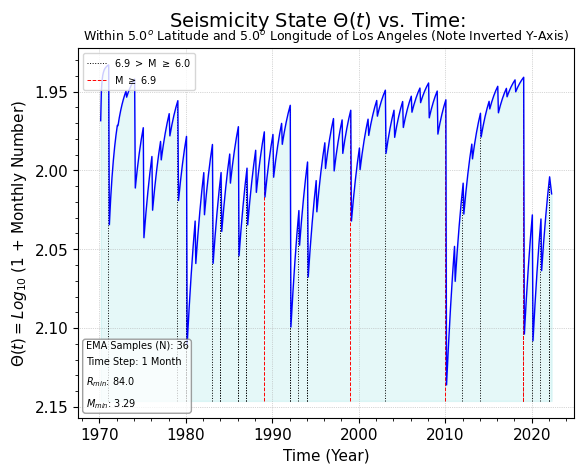

In [4351]:
# Plot_SEISR_Timeseries:
    
for i in range(len(forecast_intervals)):

    forecast_interval = forecast_intervals[i]
    
    true_positive, false_positive, true_negative, false_negative, threshold_value\
                = compute_ROC(times_window, values_window, forecast_interval, \
                mag_large, min_mag, number_thresholds, 0, 0)
        
    plot_seisr_timeseries(time_list_reduced, log_number_reduced, plot_start_year, mag_large_plot,\
        NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time, min_mag, lambda_min_mult, min_rate, \
        max_rate, forecast_interval, number_thresholds, \
        true_positive, false_positive, true_negative, false_negative, threshold_value)
                

In [4352]:

# #    if Plot_Timeseries_PPV_Precision_Information:
# # Not very useful 
    
# forecast_interval = forecast_intervals[0]

# time_list_reduced, log_number_reduced, eqs_list_reduced = \
#         compute_seisr_time_list(delta_time, lambda_min_mult, \
#         NSteps, plot_start_year, mag_large, min_mag)

# year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large_plot,min_mag)
        
# true_positive, false_positive, true_negative, false_negative, threshold_value = \
#                 compute_ROC(time_list_reduced, log_number_reduced, forecast_interval, \
#                 mag_large, min_mag, number_thresholds, 0, 0)
                
# true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
#         compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
        

# figure_name = plot_timeseries_precision_information(time_list_reduced, log_number_reduced, plot_start_year, \
#                 mag_large_plot, mag_large, min_mag,\
#                 NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time, lambda_min_mult, min_rate,\
#                 forecast_interval, number_thresholds, threshold_value, \
#                 true_positive, false_positive, true_negative, false_negative, \
#                 true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate,\
#                 year_large_eq, mag_large_eq, index_large_eq)
                
# print()


[6.6]
[1971.0]
[203]
[6.6, 6.4]
[1971.0, 1979.0]
[203, 3892]
[6.6, 6.4, 6.1]
[1971.0, 1979.0, 1980.0]
[203, 3892, 4449]
[6.6, 6.4, 6.1, 6.0]
[1971.0, 1979.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462]
[6.6, 6.4, 6.1, 6.0, 6.1]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462, 4520]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462, 4520, 4753]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2, 6.3]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0, 1980.0]
[203, 3892, 4449, 4462, 4520, 4753, 4972]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2, 6.3, 6.7]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0, 1980.0, 1983.0]
[203, 3892, 4449, 4462, 4520, 4753, 4972, 6795]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2, 6.3, 6.7, 6.2]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0, 1980.0, 1983.0, 1984.0]
[203, 3892, 4449, 4462, 4520, 4753, 4972, 6795, 7573]
[6.6, 6.4, 6.1, 6.0, 6.1, 6.2, 6.3, 6.7, 6.2, 6.1]
[1971.0, 1979.0, 1980.0, 1980.0, 1980.0, 1980.0, 1980.0, 1983.0, 1984.0, 198

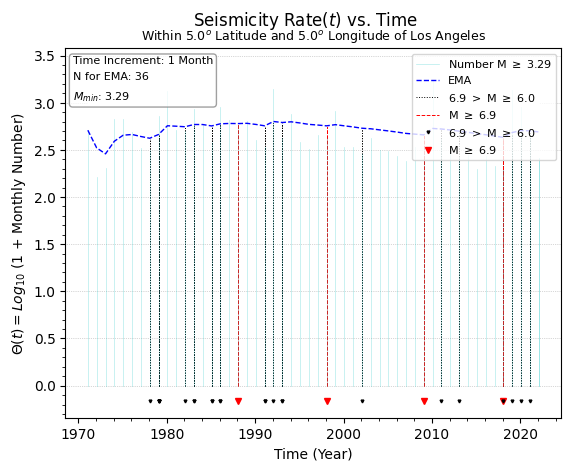

In [4353]:
# Plot_Event_Timeseries:

time_list_unadjusted, eqs_list_unadjusted = read_input_earthquake_data(delta_time, min_mag,0)

eqs_list_EMA = timeseries_to_EMA(eqs_list_unadjusted, NSteps)


eqs_list_EMA = [round(eqs_list_EMA[i],2) for i in range(len(eqs_list_EMA))]

time_list_unfiltered_reduced, eqs_list_unfiltered_reduced = \
        calc_eqs_unfiltered(time_list_unadjusted, eqs_list_unadjusted, plot_start_year)
        
time_list_EMA_reduced, eqs_list_EMA_reduced = \
        calc_eqs_unfiltered(time_list_unadjusted, eqs_list_EMA, plot_start_year)

plot_event_timeseries(time_list_unfiltered_reduced, eqs_list_unfiltered_reduced, eqs_list_EMA_reduced,\
        plot_start_year, mag_large_plot,\
        NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time, min_mag, lambda_min_mult)

In [4354]:
# #   if Plot_Event_Timeseries_Mean_EQs_Time:
    
# time_list_unadjusted, eqs_list_unadjusted = read_input_earthquake_data(delta_time, min_mag,0)

# eqs_list_EMA = timeseries_to_EMA(eqs_list_unadjusted, NSteps)


# eqs_list_EMA = [round(eqs_list_EMA[i],2) for i in range(len(eqs_list_EMA))]

# time_list_unfiltered_reduced, eqs_list_unfiltered_reduced = \
#         calc_eqs_unfiltered(time_list_unadjusted, eqs_list_unadjusted, plot_start_year)
        
# time_list_EMA_reduced, eqs_list_EMA_reduced = \
#         calc_eqs_unfiltered(time_list_unadjusted, eqs_list_EMA, plot_start_year)
        
# plot_event_timeseries_mean_eqs\
#         (time_list_unfiltered_reduced, eqs_list_unfiltered_reduced, eqs_list_EMA_reduced,\
#         timeseries, time_bins, date_bins,\
#         plot_start_year, mag_large_plot, NELng_local, SWLng_local, NELat_local, SWLat_local, Location, \
#         NSteps, delta_time, min_mag, lambda_min_mult)

In [4355]:
# # Plot_Precision_Timeseries

# forecast_interval = forecast_intervals[0]

# time_list_reduced, log_number_reduced, eqs_list_reduced = \
#         compute_seisr_time_list(delta_time, lambda_min_mult, \
#         NSteps, plot_start_year, mag_large, min_mag)

# year_large_eq, mag_large_eq, index_large_eq = get_large_earthquakes(mag_large_plot,min_mag)
    
# true_positive, false_positive, true_negative, false_negative, threshold_value = \
#             compute_ROC(time_list_reduced, log_number_reduced, forecast_interval, \
#             mag_large, min_mag, number_thresholds, 0, 0)
            
# true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
#         compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
        

# figure_name = plot_precision_timeseries(time_list_reduced, log_number_reduced, plot_start_year, \
#             mag_large_plot, mag_large, min_mag,\
#             NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time, lambda_min_mult, min_rate,\
#             forecast_interval, number_thresholds, threshold_value, \
#             true_positive, false_positive, true_negative, false_negative, \
#             true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate,\
#             year_large_eq, mag_large_eq, index_large_eq,)
            
# ################################################################

In [4356]:
# #if Plot_Temporal_ROC:


# for i in range(len(forecast_intervals)):

#     forecast_interval = forecast_intervals[i]
                
#     true_positive, false_positive, true_negative, false_negative, threshold_value\
#                 = compute_ROC(times_window, values_window, forecast_interval, \
#             mag_large, min_mag, number_thresholds, 0, 0)

#     plot_temporal_ROC(values_window, times_window, true_positive, false_positive, true_negative, false_negative, \
#             threshold_value, forecast_interval, mag_large, min_mag,plot_start_year,\
#             data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
#             Grid, Location, NSteps, delta_time, lambda_min_mult, min_rate)

In [4357]:
# # if Plot_Temporal_Shaded_ROC:

# for i in range(len(forecast_intervals)):

#     forecast_interval = forecast_intervals[i]
                
#     true_positive, false_positive, true_negative, false_negative, threshold_value\
#                 = compute_ROC(times_window, values_window, forecast_interval, \
#             mag_large, min_mag, number_thresholds, 0, 0)

#     plot_temporal_ROC_shaded(values_window, times_window, true_positive, false_positive, true_negative, false_negative, \
#             threshold_value, forecast_interval, mag_large, min_mag,plot_start_year,\
#             data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
#             Grid, Location, NSteps, delta_time, lambda_min_mult, min_rate)

In [4358]:
# #  if Plot_Temporal_TPR_FPR_Threshold:
    
# for i in range(len(forecast_intervals)):

#     forecast_interval = forecast_intervals[i]
                
#     true_positive, false_positive, true_negative, false_negative, threshold_value\
#                 = compute_ROC(times_window, values_window, forecast_interval, \
#             mag_large, min_mag, number_thresholds, 0, 0)

#     plot_temporal_TPR_FPR_Threshold\
#             (values_window, times_window, true_positive, false_positive, true_negative, false_negative, \
#             threshold_value, forecast_interval, mag_large, min_mag,plot_start_year,\
#             data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
#             Grid, Location, NSteps, delta_time, lambda_min_mult, min_rate)

In [4359]:
# #   if Plot_Precision_vs_Threshold:

# for i in range(len(forecast_intervals)):

#     forecast_interval = forecast_intervals[i]
    
#     true_positive, false_positive, true_negative, false_negative, threshold_value\
#                 = compute_ROC(times_window, values_window, forecast_interval, \
#             mag_large, min_mag, number_thresholds, 0, 0)

#     plot_precision_threshold(values_window, times_window, \
#             true_positive, false_positive, true_negative, false_negative, \
#             threshold_value, forecast_interval, mag_large, min_mag, plot_start_year,\
#             data_string_title, number_thresholds, NELng_local, SWLng_local, NELat_local, SWLat_local, \
#             Grid, Location, NSteps, delta_time, NSteps, lambda_min_mult, min_rate)

In [4360]:
# #  if Plot_Temporal_Skill_Info_vs_TW:

# forecast_interval_list = []
# temp_skill_score_list  = []

# info_random_list    =   []
# info_tpr_list       =   []
# info_fpr_list       =   []
# info_roc_list       =   []

# print()

# for i in range(69):

#     forecast_interval = 0.125 + 0.125*float(i) # Ritvik check this

#     true_positive, false_positive, true_negative, false_negative, threshold_value\
#                 = compute_ROC(times_window, values_window, forecast_interval, \
#             mag_large, min_mag, number_thresholds, 0, 0)
            
#     true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
#         compute_ROC_rates(true_positive, false_positive, true_negative, false_negative)   
        
#     info_tp, info_fp, info_random, info_roc, mean_tpr, mean_fpr = calc_ROC_information_entropy\
#         (threshold_value, true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)
        
#     temp_skill_score =   trapz(true_positive_rate, false_positive_rate)  #   Use the trapezoidal integration rule

#     print('Index, Forecast Interval (Years), Skill: ', i, forecast_interval, round(temp_skill_score,3))
#     print()
            
#     forecast_interval_list.append(forecast_interval)
#     temp_skill_score_list.append(temp_skill_score)
    
#     info_random_list.append(info_random)
#     info_tpr_list.append(info_tp)
#     info_fpr_list.append(info_fp)
#     info_roc_list.append(info_roc)

# #         print(forecast_interval_list)
# #         print(info_roc_list)
    
# plot_temporal_skill_info_vs_TW\
#         (forecast_interval_list, temp_skill_score_list, info_random_list, info_tpr_list, info_fpr_list,\
#         info_roc_list, Location, min_rate, max_rate, NSteps, delta_time, min_mag, mag_large, delta_deg_lat, \
#         delta_deg_lng, plot_start_year, number_thresholds)
                
#     #################################################################

In [4361]:
# #  if Plot_Mean_EQs_Time:
    
# forecast_interval = forecast_intervals[0]

# plot_mean_eqs_timeseries(timeseries, time_bins, date_bins, plot_start_year, mag_large_plot, forecast_interval, \
#         NELng_local, SWLng_local, NELat_local, SWLat_local, Location, NSteps, delta_time, min_mag, lambda_min_mult, min_rate)

In [4362]:
# # if Optimize_Params:
# #     
# forecast_interval = forecast_intervals[0] # value 3 years
# plot_end_year = time_list_reduced[-1] - forecast_interval   #   The last years should not be used

# year_large_eq = [round(year_large_eq[i],2) for i in range(len(year_large_eq))]

# max_skill = -1000.0
# min_skill = 10000.0

# lambda_min_mult = initial_lambda_min_mult # constant value 1

# EMA_N_list      =   []
# lambda_min_list =   []
# skill_list      =   []

# for j in range(range_lambda_min_mult):     #   number of NSteps values tested (constant value set as 10)

#     NSteps = initial_NSteps
    
#     lambda_min_mult += 0.1
    
#     lambda_min_list.append(lambda_min_mult)

#     for k in range(range_NSteps):     #   Number of lambda_min_mult values tested
    
#         NSteps += 1
        
#         if j == 0:
#             EMA_N_list.append(NSteps)

#         time_list_reduced, seisr_times_reduced, eqs_list_reduced= compute_seisr_time_list\
#                 (delta_time, lambda_min_mult, \
#                 NSteps, plot_start_year, mag_large, min_mag)

#         skill_score_seisr  = calc_ROC_skill(time_list_reduced, seisr_times_reduced, \
#                 forecast_interval, mag_large, min_mag, number_thresholds)
        
#         print('Skill, NSteps, lambda_min_mult: ',  round(skill_score_seisr,3), NSteps, round(lambda_min_mult,2))
        
#         if skill_score_seisr > max_skill:
#             max_skill = skill_score_seisr
#             NSteps_max = NSteps
#             lambda_min_mult_max = lambda_min_mult
            
#         if skill_score_seisr < min_skill:
#             min_skill = skill_score_seisr
#             NSteps_min = NSteps
#             lambda_min_mult_min = lambda_min_mult
            
#         print('')
#         print('year_large_eq: ', year_large_eq) # Check why this is wrong
#         print('mag_large_eq: ', mag_large_eq)
            
#         print()
#         print('So Far: Max_Skill, NSteps_max, lambda_min_mult_max: ', round(max_skill,3), NSteps_max, round(lambda_min_mult_max,2))
#         print()
#         print('So Far: Min_Skill, NSteps_min, lambda_min_mult_min: ', round(min_skill,3), NSteps_min, round(lambda_min_mult_min,2))
#         print('--------------------------------------------------------------')
#         print()
        
#         #   Here we create a list for the EMA N value, and for the lambda_min value.  Then we plot a countour diagram

#         skill_list.append(skill_score_seisr)
        
# plot_EMA_N_vs_lambda(EMA_N_list, lambda_min_list, skill_list, \
#         plot_start_year, mag_large_plot, forecast_interval, \
#         NELng_local, SWLng_local, NELat_local, SWLat_local, Location, plot_start_year, plot_end_year)
            
# print('Max_Skill, NSteps_max, lambda_min_mult_max: ', round(max_skill,3), NSteps_max, round(lambda_min_mult_max,2))
# print()        
# print('Min_Skill, NSteps_min, lambda_min_mult_min: ', round(min_skill,3), NSteps_min, round(lambda_min_mult_min,2))

# #################################################################

In [4363]:
# # if Plot_Spatial_ROC:


# mag_array_large, date_array_large, time_array_large, year_array_large, depth_array_large, lat_array_large, lng_array_large = \
#         read_regional_catalog(min_mag)
        
# #   ---------------------------------------------------
# #   Restricting the timeseries to only those values of interest 
# #
# ROC_range = len(time_list_reduced) -2

# date_bins_reduced       = date_bins[- ROC_range:]

# #   ---------------------------------------------------
# #
# timeseries_EMA = []
# for i in range(len(timeseries)):
#     EMA_working = []
#     ROC_list = timeseries[i][-ROC_range:]
#     mean_ROC_list    = np.mean(ROC_list)
#     Rmin_local  = lambda_min_mult * mean_ROC_list
    
#     for j in range(len(timeseries[i])):
#         if timeseries[i][j] < Rmin_local:
#             EMA_working.append(Rmin_local)
#         else:
#             EMA_working.append(timeseries[i][j])
            
#     EMA_out_list = timeseries_to_EMA(EMA_working, NSteps) # EMA average over timeseries in the ith grid box

#     timeseries_EMA.append(EMA_out_list) #   These are the time

# #   ---------------------------------------------------
# #

# timeseries_EMA_reduced  = []
# for i in range(len(timeseries_EMA)):
#     timeseries_EMA_reduced.append(timeseries_EMA[i][-ROC_range:])
    
# #   ---------------------------------------------------
# # 
# forecast_interval = forecast_intervals[0]

# plot_end_year = time_list_reduced[-1] - forecast_interval   #   The last years should not be used
# number_ROC_curves = int(plot_end_year - time_list_reduced[0]) + 1

# if number_ROC_curves > len(time_list_reduced)-1:
#     number_ROC_curves = len(time_list_reduced)-1

# plot_end_index = (number_ROC_curves) * 13
    
    
# #   ---------------------------------------------------
# # 
# ROC_data        =   []
# ROC_data_print = [0. for i in range(len(timeseries))]

# tpr_list = []
# fpr_list = []

# for index_ROC in range(0, plot_end_index, 13):

#     print_text = 'Computing ROC File '+ str(index_ROC) + ' of ' + \
#                 str(number_ROC_curves*13) #+ ' Frames on Date: ' + date_bins_reduced[index_ROC] RITVIK
#     print(print_text)
#     print()

#     ROC_gridbox_events_list = \
#                 classify_large_earthquakes_grid_boxes\
#                 (NELat_local, NELng_local, SWLat_local, SWLng_local, \
#                 grid_size, index_ROC, time_list_reduced, forecast_interval,\
#                 mag_array_large, year_array_large, depth_array_large, lat_array_large, lng_array_large)
# #                        
#     ROC_gridbox_threshold_list = sort_list_EQ_RTI_order(\
#                 ROC_gridbox_events_list,  NELat_local, NELng_local, SWLat_local, SWLng_local,\
#                 min_mag, index_ROC, timeseries_EMA_reduced, NSteps, lambda_min_mult)
                
#     true_positive, false_positive, true_negative, false_negative, threshold_value = \
#             compute_spatial_ROC(ROC_gridbox_events_list, ROC_gridbox_threshold_list)
        
#     true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate = \
#             compute_spatial_ROC_rates(\
#             true_positive, false_positive, true_negative, false_negative)
            
#     number_thresholds = len(threshold_value)
            
#     info_tp, info_fp, info_random, info_roc, mean_tpr, mean_fpr = calc_ROC_information_entropy\
#             (threshold_value, true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)
        
#     js_divergence, kl_divergence = jensen_shannon_divergence\
#             (true_positive_rate, false_positive_rate, false_negative_rate, true_negative_rate)
# # #         
#     date_of_plot = date_bins[index_ROC]
    
#     tpr_list.append(true_positive_rate)
#     fpr_list.append(false_positive_rate)
    
#     begin_date_of_plot = date_bins_reduced[0]
#     end_date_of_plot   = date_bins_reduced[plot_end_index]
    
#     plot_spatial_ROC_diagram(tpr_list, fpr_list, NSteps, \
#             delta_time,lower_mag, min_rate, min_mag, grid_size, begin_date_of_plot, end_date_of_plot, forecast_interval,\
#             delta_deg_lat, delta_deg_lng, Location, info_tp, info_random, js_divergence, kl_divergence)

# #################################################################